In [1]:
"""
Multi-step DA for the 2-layer QG system
"""

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde, norm
from Lagrangian_tracer import Lagrange_tracer_model
from conj_symm_tools import verify_conjugate_symmetry, find_non_conjugate_pairs, avg_conj_symm, map_conj_symm
from Lagrangian_DA import Lagrangian_DA_OU, Lagrangian_DA_CG, mu2psi, mu2layer, R2layer, relative_entropy_psi_k
from ene_spectrum import ene_spectrum, adjust_ik, trunc2full
from LSM_QG import solve_eigen, calibrate_OU, run_OU, eigen2layer, layer2eigen, growth_rate
from mode_truc import inv_truncate, truncate
from plot import ifftnroll, psi2q, plot_contour_fields, plot_psi_k_seriespdf, plot_layer_seriespdf, plot_psi1_k_seriespdf, plot_rmses, loop_ifft2_var, ifft2_var, plot_mog, plot_mog_k, scatterplot, calculate_skewness_kurtosis
from statsmodels.tsa.stattools import acf, ccf
from scipy.optimize import curve_fit
from scipy.io import loadmat
from scipy import sparse
import h5py
from time import time

# fix the random seed
np.random.seed(2024)


# 1. Reduced-order stochastic models

## 1.1 $\beta=22$

In [3]:
# load data
data_path = '../qg/QG_DATA_topo40_nu1e-12_beta22_K128_dt2e-3_subs.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi1_k_t_fine = np.transpose(file['psi_1_t_fine'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    s_rate = int(file['s_rate'][()][0,0])
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
psi1_k_t_fine = psi1_k_t_fine['real'] + 1j * psi1_k_t_fine['imag']
h_hat = np.fft.fft2(topo)
# print('psi1_k_t.shape',psi1_k_t.shape)

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_1_t_fine', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'utz', 'vb']>


In [4]:
# run obs model
L = 256 # number of tracers
K = psi1_k_t.shape[0]
N = psi1_k_t_fine.shape[-1]
sigma_xy = 0.1
x0 = np.random.uniform(-np.pi, np.pi, L)
y0 = np.random.uniform(-np.pi, np.pi, L)

# run model
model = Lagrange_tracer_model(N, L, K, psi1_k_t_fine, dt, sigma_xy, x0, y0, interv=8, t_interv=40000, style='square')
xt, yt, ut, vt = model.forward()   

# save data
obs = {
    'xt': xt,
    'yt': yt,
    'ut': ut,
    'vt': vt,
    'sigma_xy': sigma_xy,
    'L': L,
    'dt': dt
}
np.savez('../data/obs_K128_beta22.npz', **obs)

/grad/wang3262/Proj_1_LagrangeDA/code/Lagrangian_tracer.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  self.ut[:,:,l] = u_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids
/grad/wang3262/Proj_1_LagrangeDA/code/Lagrangian_tracer.py:132: ComplexWarning: Casting complex values to real discards the imaginary part
  self.vt[:,:,l] = v_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids


In [5]:
# truncate parameter
r_cut = 16
style = 'circle'

### 1.1.1 Linear stochastic models of eigenmodes

In [3]:
# Compute eigenvalues and eigenvectors
eigens = solve_eigen(K, beta, kd, U)
omega1 = eigens['omega1']
omega2 = eigens['omega2']
r1 = eigens['r1']
r2 = eigens['r2']

np.savez('../data/eigens_K128_beta22.npz', **eigens)
np.where(np.isnan(r1))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [8]:
# Truth of eigenmodes
psi_k_t, tau_k_t = layer2eigen(K, r_cut, r1, r2, psi1_k_t, psi2_k_t, style=style)

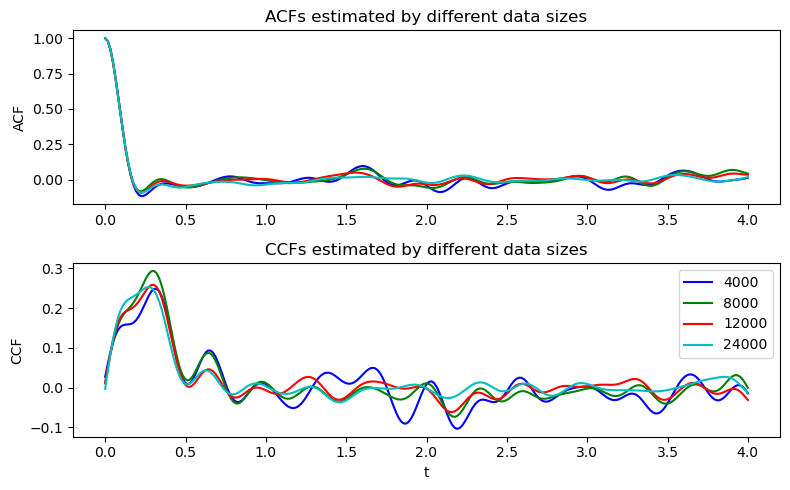

In [8]:
# Vary the amount of data used to estimate ACF    
def cf_eigen(psi1_hat_t, psi2_hat_t, r1, r2, ikx, iky, Lag):
    eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
    eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
    psi1_hat = eigenmode[0,:] 
    psi2_hat = eigenmode[1,:]
    acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
    acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
    ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
    ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts
    
    return acf_psi1, acf_psi2, ccf_psi1, ccf_psi2

nums = [4000, 8000, 12000, 24000]
Lag = 250  # lag for computing the ACF
tt = np.linspace(0, Lag*dt*s_rate, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
acf_psi = np.zeros((Lag+1,len(nums)))
acf_tau = np.zeros((Lag+1,len(nums)))
ccf_psi = np.zeros((Lag+1,len(nums)))
ccf_tau = np.zeros((Lag+1,len(nums)))

ikx = 3; iky = 0;
for inum,num in enumerate(nums):
    acf_psi[:,inum], acf_tau[:,inum], ccf_psi[:,inum], ccf_tau[:,inum] = cf_eigen(psi1_k_t[:,:,:num+Lag], psi2_k_t[:,:,:num+Lag], r1, r2, ikx, iky, Lag)
    
plt.figure(figsize=(8, 5))  # Set the figure size (optional)
colors = ['b', 'g', 'r', 'c','k']  # Colors for different lines
labels = [f'{num}' for num in nums]  # Labels for the legend

plt.subplot(2, 1, 1)
for i in range(len(nums)):
    plt.plot(tt, acf_psi[:, i], color=colors[i], label=labels[i])
plt.ylabel('ACF')
plt.title('ACFs estimated by different data sizes')

plt.subplot(2, 1, 2)
for i in range(len(nums)):
    plt.plot(tt, ccf_psi[:, i], color=colors[i], label=labels[i])
plt.xlabel('t')
plt.ylabel('CCF')
plt.title('CCFs estimated by different data sizes')
plt.legend()
plt.tight_layout()
plt.savefig('./Lagrangian_DA/acf_ccf_diffN_K128_beta22_tr.png')
plt.show()

In [9]:
# Model calibration
est_params = calibrate_OU(r1, psi_k_t, tau_k_t, K, dt*s_rate, Lag=250, r_cut=r_cut, style=style, corr_noise=False)
gamma_est = est_params['gamma']
omega_est_ccf = est_params['omega_ccf']
omega_est_acf = est_params['omega_acf']
omega_est = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']

np.savez('../data/est_paras_ou_K128_beta22_tr.npz', **est_params)

# correlated noise
est_params = calibrate_OU(r1, psi_k_t, tau_k_t, K, dt*s_rate, Lag=250, r_cut=r_cut, style=style, corr_noise=True)
sigma_cn = est_params['sigma']
cov_cn = est_params['cov']

np.savez('../data/est_paras_cn_ou_K128_beta22_tr.npz', **est_params)

/grad/wang3262/Proj_1_LagrangeDA/code/LSM_QG.py:123: OptimizeWarning: Covariance of the parameters could not be estimated
  x1, _ = curve_fit(ACF, tt, acf_psi, p0=x0, check_finite=True, maxfev=2000)
/grad/wang3262/Proj_1_LagrangeDA/code/LSM_QG.py:131: OptimizeWarning: Covariance of the parameters could not be estimated
  x2, _ = curve_fit(ACF, tt, acf_tau, p0=x0, check_finite=True, maxfev=2000)
/grad/wang3262/Proj_1_LagrangeDA/code/LSM_QG.py:191: RuntimeWarning: invalid value encountered in divide
  pre2 = np.sqrt((f1 + f2 - 2 * pre1) / ((f1 - f2)**2 + 8*(f3**2 + f4**2)))


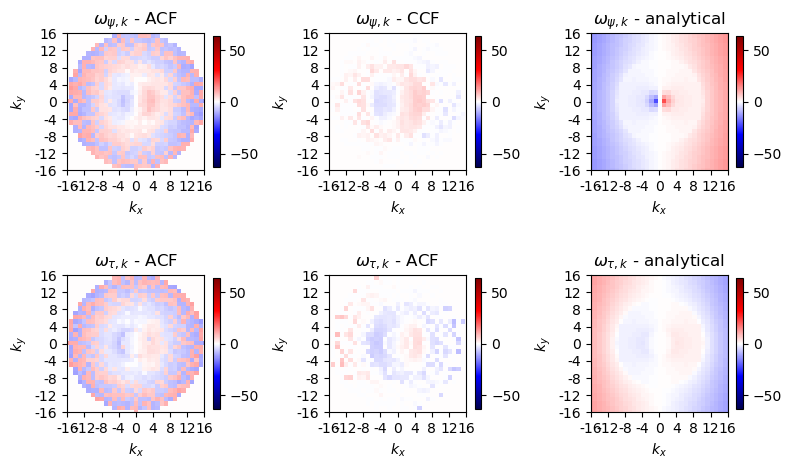

In [10]:
# Plot modes of omega
nrow = 2; ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(8,5))

dataplot = np.zeros((K,K,nrow, ncol))
dataplot[:,:,0,0] = omega_est[:,:,0]
dataplot[:,:,0,1] = omega_est_ccf[:,:,0]
dataplot[:,:,0,2] = omega1.real
dataplot[:,:,1,0] = omega_est[:,:,1]
dataplot[:,:,1,1] = omega_est_ccf[:,:,1]
dataplot[:,:,1,2] = omega2.real

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx = np.fft.fftfreq(K) * K
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 
r = r_cut

for i in range(2):
    for j in range(3):
        n_tick = K//8*2
        maxabs = np.max(abs(dataplot[:, :, 0, 2]))
        im = axs[i,j].imshow(dataplot[:, :, i, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
        axs[i,j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False)) 
        axs[i,j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))
        axs[i,j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_xlim(K//2-r, K//2+r) 
        axs[i,j].set_ylim(K//2-r, K//2+r)
        axs[i,j].set_xlabel('$k_x$')
        axs[i,j].set_ylabel('$k_y$')
        fig.colorbar(im, ax=axs[i,j], shrink=0.7)

axs[0,0].set_title(r'$\omega_{\psi,k}$ - ACF')
axs[0,1].set_title(r'$\omega_{\psi,k}$ - CCF')
axs[0,2].set_title(r'$\omega_{\psi,k}$ - analytical')
axs[1,0].set_title(r'$\omega_{\tau,k}$ - ACF')
axs[1,1].set_title(r'$\omega_{\tau,k}$ - ACF')
axs[1,2].set_title(r'$\omega_{\tau,k}$ - analytical')

plt.tight_layout()
plt.savefig('./Lagrangian_DA/omega_compare_K128_beta22_tr.png', dpi=100)
plt.show()

In [11]:
# Run OU process
N = 40000
# get the initial condition
psi_k0 = psi_k_t[:,:,0]
tau_k0 = tau_k_t[:,:,0]
psi_k, tau_k = run_OU(psi_k0, tau_k0, K, N, dt, r_cut, r1, r2, gamma_est, omega_est, f_est, sigma_est, style=style, s_rate=s_rate, corr_noise=False)

# save data
ou_run = {
    'psi_k': psi_k,
    'tau_k': tau_k,
    'N': N,
    'r_cut':r_cut,
    'dt': dt
}
np.savez('../data/ou_run_K128_beta22_tr.npz', **ou_run)

# correlated noise
psi_k_cn, tau_k_cn = run_OU(psi_k0, tau_k0, K, N, dt, r_cut, r1, r2, gamma_est, omega_est, f_est, sigma_cn, style=style, s_rate=s_rate, corr_noise=True, cov=cov_cn)

# save data
ou_run = {
    'psi_k': psi_k_cn,
    'tau_k': tau_k_cn,
    'N': N,
    'r_cut':r_cut,
    'dt': dt
}
np.savez('../data/ou_run_cn_K128_beta22_tr.npz', **ou_run)

In [12]:
# ifft to real space
interv = 10
psi1_k, psi2_k = eigen2layer(K,r_cut,r1,r2,psi_k,tau_k,style)
psi1_k_cn, psi2_k_cn = eigen2layer(K,r_cut,r1,r2,psi_k_cn,tau_k_cn,style)

psi1_ifft = np.fft.ifft2(psi1_k[:, :, ::interv], axes=(0,1))
psi1_ifft_t = np.fft.ifft2(psi1_k_t[:, :, ::interv], axes=(0,1))
psi2_ifft = np.fft.ifft2(psi2_k[:, :, ::interv], axes=(0,1))
psi2_ifft_t = np.fft.ifft2(psi2_k_t[:, :, ::interv], axes=(0,1))
psi1_ifft_cn = np.fft.ifft2(psi1_k_cn[:, :, ::interv], axes=(0,1))
psi2_ifft_cn = np.fft.ifft2(psi2_k_cn[:, :, ::interv], axes=(0,1))

psi1_ifft = np.roll(psi1_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft = np.roll(psi1_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft = np.roll(psi2_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft = np.roll(psi2_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft_t = np.roll(psi1_ifft_t, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft_t = np.roll(psi1_ifft_t, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft_t = np.roll(psi2_ifft_t, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft_t = np.roll(psi2_ifft_t, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi1_cn_ifft = np.roll(psi1_ifft_cn, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi1_cn_ifft = np.roll(psi1_ifft_cn, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi2_cn_ifft = np.roll(psi2_ifft_cn, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi2_cn_ifft = np.roll(psi2_ifft_cn, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)

In [13]:
psi1_ifft_t = psi1_ifft_t[:,:,:500]
psi2_ifft_t = psi2_ifft_t[:,:,:500]

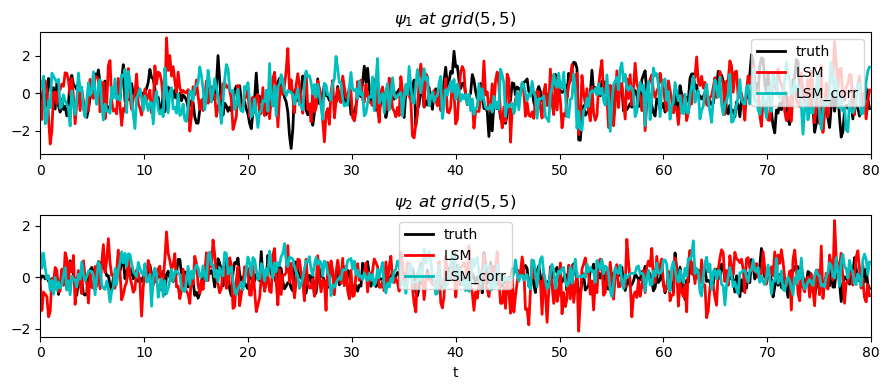

In [14]:
# Plotting trajectories
mode = 5
plt.figure(figsize=(9, 4))
plt.subplot(2, 1, 1)
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi1_ifft_t[mode,mode,:]), 'k', linewidth=2, label='truth')
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi1_ifft[mode,mode,:]), 'r', linewidth=2, label='LSM')
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi1_ifft_cn[mode,mode,:]), 'c', linewidth=2, label='LSM_corr')
plt.title(r'$\psi_1\ at\ grid({{{:d},{:d}}})$'.format(mode, mode))
plt.xlim(0,N*dt)
plt.legend()
# plt.xlabel('t')

plt.subplot(2, 1, 2)
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi2_ifft_t[mode,mode,:]), 'k', linewidth=2, label='truth')
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi2_ifft[mode,mode,:]), 'r', linewidth=2, label='LSM')
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi2_ifft_cn[mode,mode,:]), 'c', linewidth=2, label='LSM_corr')
plt.title(r'$\psi_2\ at\ grid({{{:d},{:d}}})$'.format(mode, mode))
plt.legend()
plt.xlabel('t')
plt.xlim(0,N*dt)
plt.tight_layout()
plt.savefig('./LSM/psi_layer_ou_truth_K128_beta22_tr.png', dpi=100)
plt.show()

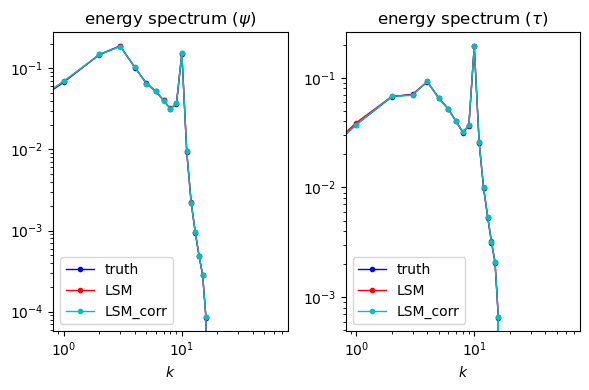

In [18]:
# energy spectrum of eigenmodes
t_avrg = 8000
psi_hat_t = np.concatenate((psi_k_t[:,:,None,-t_avrg:], tau_k_t[:,:,None,-t_avrg:]), axis=2)
ke, ape, ene, etp, e_mode = ene_spectrum(np.transpose(psi_hat_t, axes=(3,0,1,2)), K, kd, topo, r_cut)
psi_hat = np.concatenate((psi_k[:,:,None,-t_avrg:], tau_k[:,:,None,-t_avrg:]), axis=2)
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(np.transpose(psi_hat, axes=(3,0,1,2)), K, kd, topo, r_cut)
psi_hat = np.concatenate((psi_k_cn[:,:,None,-t_avrg:], tau_k_cn[:,:,None,-t_avrg:]), axis=2)
ke_ou_cn, ape_ou_cn, ene_ou_cn, etp_ou_cn, e_mode_ou_cn = ene_spectrum(np.transpose(psi_hat, axes=(3,0,1,2)), K, kd, topo, r_cut)

# Plot spectrum
nrow = 1; ncol = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6,4))

dataplot = np.zeros((K//2 + 1, 3, nrow, ncol))
dataplot[:,0,0,0] = e_mode[:,0]
dataplot[:,1,0,0] = e_mode_ou[:,0]
dataplot[:,2,0,0] = e_mode_ou_cn[:,0]
dataplot[:,0,0,1] = e_mode[:,1]
dataplot[:,1,0,1] = e_mode_ou[:,1]
dataplot[:,2,0,1] = e_mode_ou_cn[:,1]

for i in range(2):
    n_tick = 4
    axs[i].loglog(np.arange(0, K//2 + 1), dataplot[:,0,0,i], '.-b', linewidth=1, label='truth')
    axs[i].loglog(np.arange(0, K//2 + 1), dataplot[:,1,0,i], '.-r', linewidth=1, label='LSM')
    axs[i].loglog(np.arange(0, K//2 + 1), dataplot[:,2,0,i], '.-c', linewidth=1, label='LSM_corr')
#         axs[i,j].set_ylim(K//2-r, K//2+r)
    axs[i].set_xlabel('$k$')
    axs[i].legend()

axs[0].set_title(r'energy spectrum ($\psi$)')
axs[1].set_title(r'energy spectrum ($\tau$)')

plt.tight_layout()
plt.savefig('./LSM/spectrum_eigen_K128_beta22_tr.png', dpi=100)
plt.show()

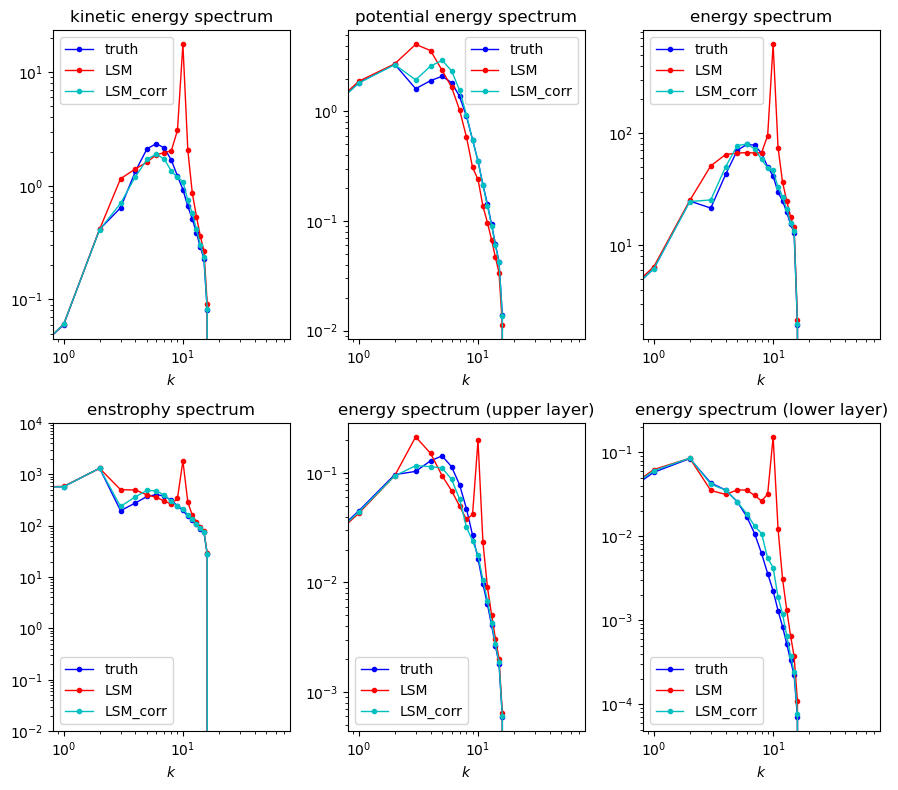

In [17]:
# energy spectrum of layers
t_avrg = 8000
psi_hat_t = np.concatenate((psi1_k_t[:,:,None,-t_avrg:], psi2_k_t[:,:,None,-t_avrg:]), axis=2)
ke, ape, ene, etp, e_mode = ene_spectrum(np.transpose(psi_hat_t, axes=(3,0,1,2)), K, kd, topo, r_cut)
psi_hat = np.concatenate((psi1_k[:,:,None,-t_avrg:], psi2_k[:,:,None,-t_avrg:]), axis=2)
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(np.transpose(psi_hat, axes=(3,0,1,2)), K, kd, topo, r_cut)
psi_hat = np.concatenate((psi1_k_cn[:,:,None,-t_avrg:], psi2_k_cn[:,:,None,-t_avrg:]), axis=2)
ke_ou_cn, ape_ou_cn, ene_ou_cn, etp_ou_cn, e_mode_ou_cn = ene_spectrum(np.transpose(psi_hat, axes=(3,0,1,2)), K, kd, topo, r_cut)

# Plot spectrum
nrow = 2; ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(9,8))

dataplot = np.zeros((K//2 + 1, 3, nrow, ncol))
dataplot[:,0,0,0] = ke
dataplot[:,1,0,0] = ke_ou
dataplot[:,2,0,0] = ke_ou_cn
dataplot[:,0,0,1] = ape
dataplot[:,1,0,1] = ape_ou
dataplot[:,2,0,1] = ape_ou_cn
dataplot[:,0,0,2] = ene
dataplot[:,1,0,2] = ene_ou
dataplot[:,2,0,2] = ene_ou_cn
dataplot[:,0,1,0] = etp
dataplot[:,1,1,0] = etp_ou
dataplot[:,2,1,0] = etp_ou_cn
dataplot[:,0,1,1] = e_mode[:,0]
dataplot[:,1,1,1] = e_mode_ou[:,0]
dataplot[:,2,1,1] = e_mode_ou_cn[:,0]
dataplot[:,0,1,2] = e_mode[:,1]
dataplot[:,1,1,2] = e_mode_ou[:,1]
dataplot[:,2,1,2] = e_mode_ou_cn[:,1]

for i in range(2):
    for j in range(3):
        n_tick = 4
        axs[i,j].loglog(np.arange(0, K//2 + 1), dataplot[:,0,i,j], '.-b', linewidth=1, label='truth')
        axs[i,j].loglog(np.arange(0, K//2 + 1), dataplot[:,1,i,j], '.-r', linewidth=1, label='LSM')
        axs[i,j].loglog(np.arange(0, K//2 + 1), dataplot[:,2,i,j], '.-c', linewidth=1, label='LSM_corr')
#         axs[i,j].set_ylim(K//2-r, K//2+r)
        axs[i,j].set_xlabel('$k$')
        axs[i,j].legend()

# axs[0,0].set_ylim(1e-5, 10)
axs[1,0].set_ylim(1e-2, 10000)

axs[0,0].set_title('kinetic energy spectrum')
axs[0,1].set_title('potential energy spectrum')
axs[0,2].set_title('energy spectrum')
axs[1,0].set_title('enstrophy spectrum')
axs[1,1].set_title(r'energy spectrum (upper layer)')
axs[1,2].set_title(r'energy spectrum (lower layer)')

plt.tight_layout()
plt.savefig('./LSM/spectrum_layer_K128_beta22_tr.png', dpi=100)
plt.show()

### 1.1.2 Nonlinear CG stochastic model

In [9]:
N_chunk = 5000
cg_da = Lagrangian_DA_CG(K, kd, beta, kappa, nu, U, h_hat, r_cut, style)
Sigma1, Sigma2 = cg_da.calibrate_sigma(N_chunk, dt*s_rate, psi1_k_t, psi2_k_t)

# save data
data = {
    'Sigma1': Sigma1,
    'Sigma2': Sigma2
}
np.savez('../data/Sigma_cali_CGDA_K128_beta22_tr.npz', **data)

/grad/wang3262/Proj_1_LagrangeDA/code/Lagrangian_DA.py:114: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / invCk


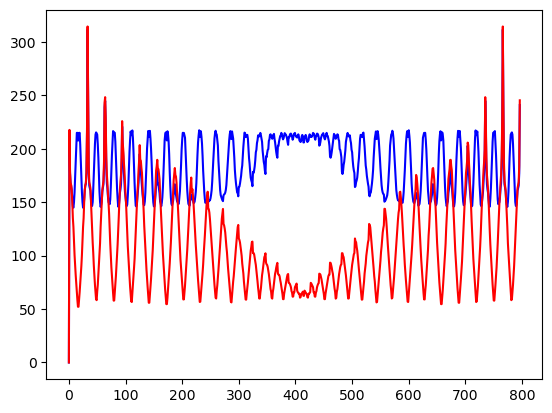

In [10]:
plt.plot(Sigma1, 'b')
plt.plot(Sigma2, 'r')

In [8]:
Sigma1_KK = inv_truncate(Sigma1, r_cut, K, style)
Sigma2_KK = inv_truncate(Sigma2, r_cut, K, style)

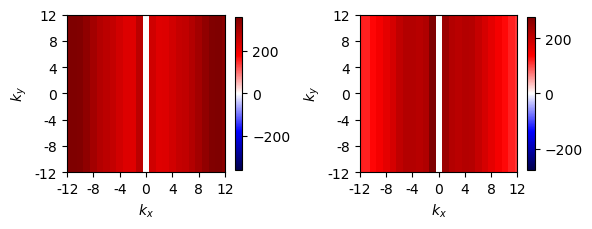

In [10]:
# Plot modes of omega
nrow = 1; ncol = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6,3))

dataplot = np.zeros((K,K,nrow, ncol))
dataplot[:,:,0,0] = Sigma1_KK
dataplot[:,:,0,1] = Sigma2_KK

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx = np.fft.fftfreq(K) * K
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 
r = r_cut

for i in range(nrow):
    for j in range(ncol): 
        n_tick = K//8*2
        maxabs = np.max(abs(dataplot[:, :, i, j]))
        im = axs[j].imshow(dataplot[:, :, i, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
        axs[j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False)) 
        axs[j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))
        axs[j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[j].set_xlim(K//2-r, K//2+r) 
        axs[j].set_ylim(K//2-r, K//2+r)
        axs[j].set_xlabel('$k_x$')
        axs[j].set_ylabel('$k_y$')
        fig.colorbar(im, ax=axs[j], shrink=0.6)

plt.tight_layout()
plt.show()

## 1.2 $\beta=111$

In [2]:
# load data
data_path = '../qg/QG_DATA_topo40_nu1e-12_beta111_K128_dt2e-3_subs.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi1_k_t_fine = np.transpose(file['psi_1_t_fine'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    s_rate = int(file['s_rate'][()][0,0])
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
psi1_k_t_fine = psi1_k_t_fine['real'] + 1j * psi1_k_t_fine['imag']
h_hat = np.fft.fft2(topo)
print('psi1_k_t.shape',psi1_k_t.shape)

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_1_t_fine', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'utz', 'vb']>
psi1_k_t.shape (128, 128, 25000)


In [5]:
# run obs model
L = 256 # number of tracers
K = psi1_k_t.shape[0]
N = psi1_k_t_fine.shape[-1]
sigma_xy = 0.1
x0 = np.random.uniform(-np.pi, np.pi, L)
y0 = np.random.uniform(-np.pi, np.pi, L)

# run model
model = Lagrange_tracer_model(N, L, K, psi1_k_t_fine, dt, sigma_xy, x0, y0, interv=8, t_interv=40000, style='square')
xt, yt, ut, vt = model.forward()   

# save data
obs = {
    'xt': xt,
    'yt': yt,
    'ut': ut,
    'vt': vt,
    'sigma_xy': sigma_xy,
    'L': L,
    'dt': dt
}
np.savez('../data/obs_K128_beta111.npz', **obs)

/grad/wang3262/Proj_1_LagrangeDA/code/Lagrangian_tracer.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  self.ut[:,:,l] = u_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids
/grad/wang3262/Proj_1_LagrangeDA/code/Lagrangian_tracer.py:132: ComplexWarning: Casting complex values to real discards the imaginary part
  self.vt[:,:,l] = v_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids


In [4]:
# truncate parameter
r_cut = 16
style = 'circle'

### 1.2.1 Linear stochastic models of eigenmodes

In [3]:
# Compute eigenvalues and eigenvectors
eigens = solve_eigen(K, beta, kd, U)
omega1 = eigens['omega1']
omega2 = eigens['omega2']
r1 = eigens['r1']
r2 = eigens['r2']

np.savez('../data/eigens_K128_beta111.npz', **eigens)
np.where(np.isnan(r1))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [5]:
# Truth of eigenmodes
psi_k_t, tau_k_t = layer2eigen(K, r_cut, r1, r2, psi1_k_t, psi2_k_t, style=style)

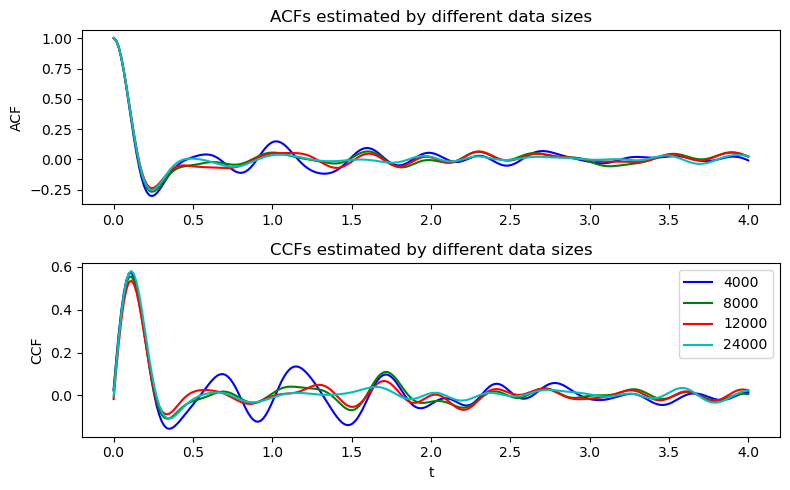

In [18]:
# Vary the amount of data used to estimate ACF    
def cf_eigen(psi1_hat_t, psi2_hat_t, r1, r2, ikx, iky, Lag):
    eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
    eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
    psi1_hat = eigenmode[0,:] 
    psi2_hat = eigenmode[1,:]
    acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
    acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
    ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
    ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts
    
    return acf_psi1, acf_psi2, ccf_psi1, ccf_psi2

nums = [4000, 8000, 12000, 24000]
Lag = 250  # lag for computing the ACF
tt = np.linspace(0, Lag*dt*s_rate, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
acf_psi = np.zeros((Lag+1,len(nums)))
acf_tau = np.zeros((Lag+1,len(nums)))
ccf_psi = np.zeros((Lag+1,len(nums)))
ccf_tau = np.zeros((Lag+1,len(nums)))

ikx = 3; iky = 0;
for inum,num in enumerate(nums):
    acf_psi[:,inum], acf_tau[:,inum], ccf_psi[:,inum], ccf_tau[:,inum] = cf_eigen(psi1_k_t[:,:,:num+Lag], psi2_k_t[:,:,:num+Lag], r1, r2, ikx, iky, Lag)
    
plt.figure(figsize=(8, 5))  # Set the figure size (optional)
colors = ['b', 'g', 'r', 'c','k']  # Colors for different lines
labels = [f'{num}' for num in nums]  # Labels for the legend

plt.subplot(2, 1, 1)
for i in range(len(nums)):
    plt.plot(tt, acf_psi[:, i], color=colors[i], label=labels[i])
plt.ylabel('ACF')
plt.title('ACFs estimated by different data sizes')

plt.subplot(2, 1, 2)
for i in range(len(nums)):
    plt.plot(tt, ccf_psi[:, i], color=colors[i], label=labels[i])
plt.xlabel('t')
plt.ylabel('CCF')
plt.title('CCFs estimated by different data sizes')
plt.legend()
plt.tight_layout()
plt.savefig('./Lagrangian_DA/acf_ccf_diffN_K128_beta111_tr.png')
plt.show()

In [18]:
# Model calibration
est_params = calibrate_OU(r1, psi_k_t, tau_k_t, K, dt*s_rate, Lag=250, r_cut=r_cut, style=style, corr_noise=False)
gamma_est = est_params['gamma']
omega_est_ccf = est_params['omega_ccf']
omega_est_acf = est_params['omega_acf']
omega_est = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']

np.savez('../data/est_paras_ou_K128_beta111_tr.npz', **est_params)

# correlated noise
est_params = calibrate_OU(r1, psi_k_t, tau_k_t, K, dt*s_rate, Lag=250, r_cut=r_cut, style=style, corr_noise=True)
sigma_cn = est_params['sigma']
cov_cn = est_params['cov']

np.savez('../data/est_paras_cn_ou_K128_beta111_tr.npz', **est_params)

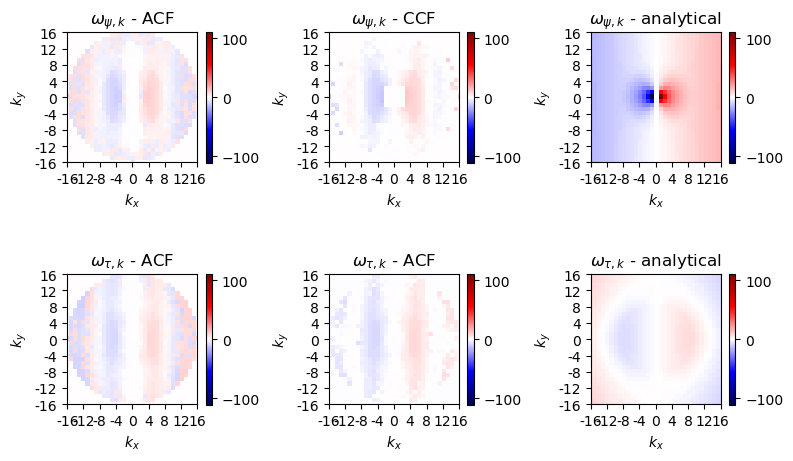

In [19]:
# Plot modes of omega
nrow = 2; ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(8,5))

dataplot = np.zeros((K,K,nrow, ncol))
dataplot[:,:,0,0] = omega_est[:,:,0]
dataplot[:,:,0,1] = omega_est_ccf[:,:,0]
dataplot[:,:,0,2] = omega1.real
dataplot[:,:,1,0] = omega_est[:,:,1]
dataplot[:,:,1,1] = omega_est_ccf[:,:,1]
dataplot[:,:,1,2] = omega2.real

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx = np.fft.fftfreq(K) * K
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 
r = r_cut

for i in range(2):
    for j in range(3):
        n_tick = K//8*2
        maxabs = np.max(abs(dataplot[:, :, 0, 2]))
        im = axs[i,j].imshow(dataplot[:, :, i, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
        axs[i,j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False)) 
        axs[i,j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))
        axs[i,j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_xlim(K//2-r, K//2+r) 
        axs[i,j].set_ylim(K//2-r, K//2+r)
        axs[i,j].set_xlabel('$k_x$')
        axs[i,j].set_ylabel('$k_y$')
        fig.colorbar(im, ax=axs[i,j], shrink=0.7)

axs[0,0].set_title(r'$\omega_{\psi,k}$ - ACF')
axs[0,1].set_title(r'$\omega_{\psi,k}$ - CCF')
axs[0,2].set_title(r'$\omega_{\psi,k}$ - analytical')
axs[1,0].set_title(r'$\omega_{\tau,k}$ - ACF')
axs[1,1].set_title(r'$\omega_{\tau,k}$ - ACF')
axs[1,2].set_title(r'$\omega_{\tau,k}$ - analytical')

plt.tight_layout()
plt.savefig('./Lagrangian_DA/omega_compare_K128_beta111_tr.png', dpi=100)
plt.show()

In [8]:
# Run OU process
N = 40000
# get the initial condition
psi_k0 = psi_k_t[:,:,0]
tau_k0 = tau_k_t[:,:,0]
psi_k, tau_k = run_OU(psi_k0, tau_k0, K, N, dt, r_cut, r1, r2, gamma_est, omega_est, f_est, sigma_est, style=style, s_rate=s_rate, corr_noise=False)

# save data
ou_run = {
    'psi_k': psi_k,
    'tau_k': tau_k,
    'N': N,
    'r_cut':r_cut,
    'dt': dt
}
np.savez('../data/ou_run_K128_beta111_tr.npz', **ou_run)

# correlated noise
psi_k_cn, tau_k_cn = run_OU(psi_k0, tau_k0, K, N, dt, r_cut, r1, r2, gamma_est, omega_est, f_est, sigma_cn, style=style, s_rate=s_rate, corr_noise=True, cov=cov_cn)

# save data
ou_run = {
    'psi_k': psi_k_cn,
    'tau_k': tau_k_cn,
    'N': N,
    'r_cut':r_cut,
    'dt': dt
}
np.savez('../data/ou_run_cn_K128_beta111_tr.npz', **ou_run)

In [ ]:
# ifft to real space
interv = 10
psi1_k, psi2_k = eigen2layer(K,r_cut,r1,r2,psi_k,tau_k,style)
psi1_k_cn, psi2_k_cn = eigen2layer(K,r_cut,r1,r2,psi_k_cn,tau_k_cn,style)

psi1_ifft = np.fft.ifft2(psi1_k[:, :, ::interv], axes=(0,1))
psi1_ifft_t = np.fft.ifft2(psi1_k_t[:, :, ::interv], axes=(0,1))
psi2_ifft = np.fft.ifft2(psi2_k[:, :, ::interv], axes=(0,1))
psi2_ifft_t = np.fft.ifft2(psi2_k_t[:, :, ::interv], axes=(0,1))
psi1_ifft_cn = np.fft.ifft2(psi1_k_cn[:, :, ::interv], axes=(0,1))
psi2_ifft_cn = np.fft.ifft2(psi2_k_cn[:, :, ::interv], axes=(0,1))

psi1_ifft = np.roll(psi1_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft = np.roll(psi1_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft = np.roll(psi2_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft = np.roll(psi2_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft_t = np.roll(psi1_ifft_t, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft_t = np.roll(psi1_ifft_t, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft_t = np.roll(psi2_ifft_t, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft_t = np.roll(psi2_ifft_t, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi1_cn_ifft = np.roll(psi1_ifft_cn, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi1_cn_ifft = np.roll(psi1_ifft_cn, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi2_cn_ifft = np.roll(psi2_ifft_cn, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi2_cn_ifft = np.roll(psi2_ifft_cn, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)

In [35]:
psi1_ifft_t = psi1_ifft_t[:,:,:500]
psi2_ifft_t = psi2_ifft_t[:,:,:500]

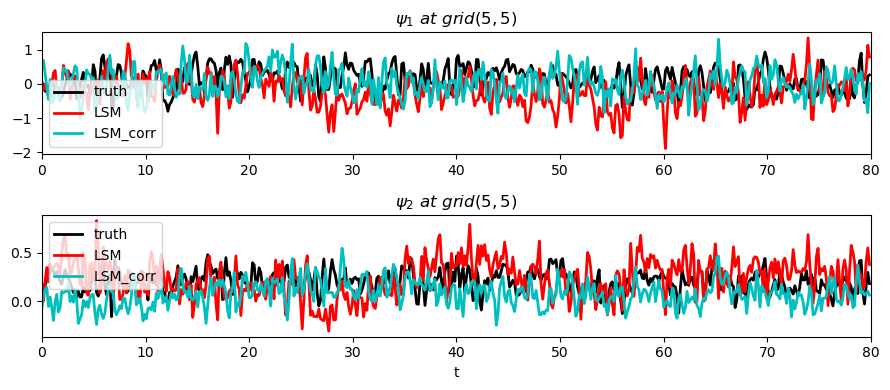

In [37]:
# Plotting trajectories
mode = 5
plt.figure(figsize=(9, 4))
plt.subplot(2, 1, 1)
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi1_ifft_t[mode,mode,:]), 'k', linewidth=2, label='truth')
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi1_ifft[mode,mode,:]), 'r', linewidth=2, label='LSM')
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi1_ifft_cn[mode,mode,:]), 'c', linewidth=2, label='LSM_corr')
plt.title(r'$\psi_1\ at\ grid({{{:d},{:d}}})$'.format(mode, mode))
plt.xlim(0,N*dt)
plt.legend()
# plt.xlabel('t')

plt.subplot(2, 1, 2)
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi2_ifft_t[mode,mode,:]), 'k', linewidth=2, label='truth')
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi2_ifft[mode,mode,:]), 'r', linewidth=2, label='LSM')
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi2_ifft_cn[mode,mode,:]), 'c', linewidth=2, label='LSM_corr')
plt.title(r'$\psi_2\ at\ grid({{{:d},{:d}}})$'.format(mode, mode))
plt.legend()
plt.xlabel('t')
plt.xlim(0,N*dt)
plt.tight_layout()
plt.savefig('./LSM/psi_layer_ou_truth_K128_beta111_tr.png', dpi=100)
plt.show()

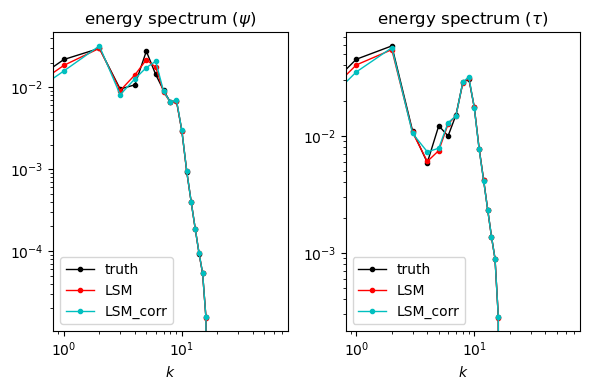

In [39]:
# energy spectrum of eigenmodes
t_avrg = 8000
psi_hat_t = np.concatenate((psi_k_t[:,:,None,-t_avrg:], tau_k_t[:,:,None,-t_avrg:]), axis=2)
ke, ape, ene, etp, e_mode = ene_spectrum(np.transpose(psi_hat_t, axes=(3,0,1,2)), K, kd, topo, r_cut)
psi_hat = np.concatenate((psi_k[:,:,None,-t_avrg:], tau_k[:,:,None,-t_avrg:]), axis=2)
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(np.transpose(psi_hat, axes=(3,0,1,2)), K, kd, topo, r_cut)
psi_hat = np.concatenate((psi_k_cn[:,:,None,-t_avrg:], tau_k_cn[:,:,None,-t_avrg:]), axis=2)
ke_ou_cn, ape_ou_cn, ene_ou_cn, etp_ou_cn, e_mode_ou_cn = ene_spectrum(np.transpose(psi_hat, axes=(3,0,1,2)), K, kd, topo, r_cut)

# Plot spectrum
nrow = 1; ncol = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6,4))

dataplot = np.zeros((K//2 + 1, 3, nrow, ncol))
dataplot[:,0,0,0] = e_mode[:,0]
dataplot[:,1,0,0] = e_mode_ou[:,0]
dataplot[:,2,0,0] = e_mode_ou_cn[:,0]
dataplot[:,0,0,1] = e_mode[:,1]
dataplot[:,1,0,1] = e_mode_ou[:,1]
dataplot[:,2,0,1] = e_mode_ou_cn[:,1]

for i in range(2):
    n_tick = 4
    axs[i].loglog(np.arange(0, K//2 + 1), dataplot[:,0,0,i], '.-k', linewidth=1, label='truth')
    axs[i].loglog(np.arange(0, K//2 + 1), dataplot[:,1,0,i], '.-r', linewidth=1, label='LSM')
    axs[i].loglog(np.arange(0, K//2 + 1), dataplot[:,2,0,i], '.-c', linewidth=1, label='LSM_corr')
#         axs[i,j].set_ylim(K//2-r, K//2+r)
    axs[i].set_xlabel('$k$')
    axs[i].legend()

axs[0].set_title(r'energy spectrum ($\psi$)')
axs[1].set_title(r'energy spectrum ($\tau$)')

plt.tight_layout()
plt.savefig('./LSM/spectrum_eigen_K128_beta111_tr.png', dpi=100)
plt.show()

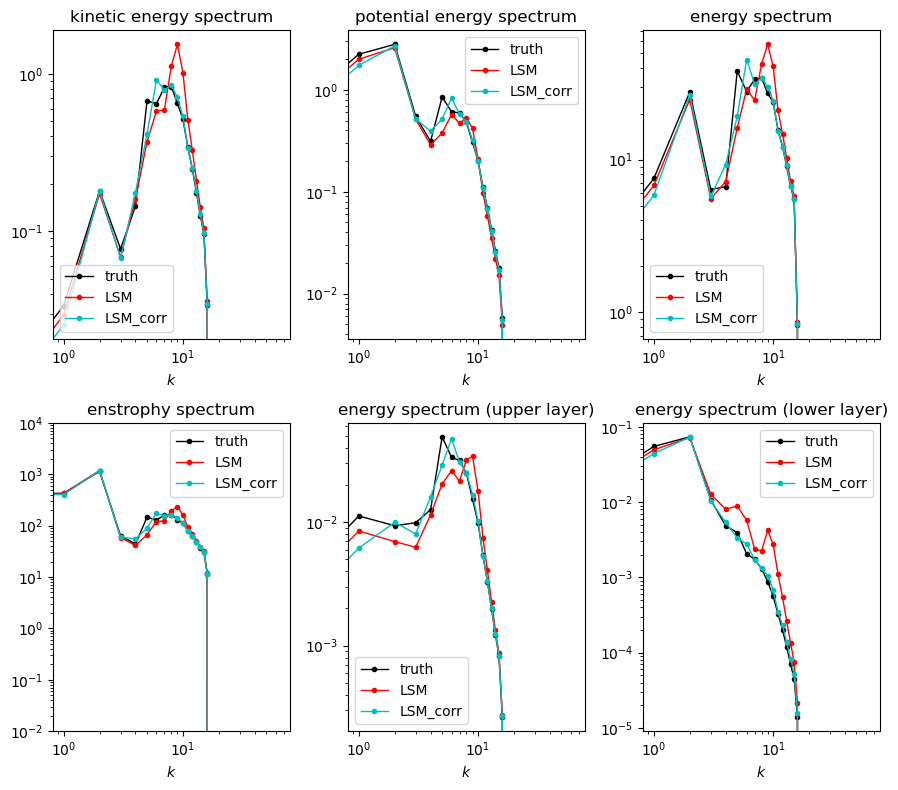

In [40]:
# energy spectrum of layers
t_avrg = 8000
psi_hat_t = np.concatenate((psi1_k_t[:,:,None,-t_avrg:], psi2_k_t[:,:,None,-t_avrg:]), axis=2)
ke, ape, ene, etp, e_mode = ene_spectrum(np.transpose(psi_hat_t, axes=(3,0,1,2)), K, kd, topo, r_cut)
psi_hat = np.concatenate((psi1_k[:,:,None,-t_avrg:], psi2_k[:,:,None,-t_avrg:]), axis=2)
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(np.transpose(psi_hat, axes=(3,0,1,2)), K, kd, topo, r_cut)
psi_hat = np.concatenate((psi1_k_cn[:,:,None,-t_avrg:], psi2_k_cn[:,:,None,-t_avrg:]), axis=2)
ke_ou_cn, ape_ou_cn, ene_ou_cn, etp_ou_cn, e_mode_ou_cn = ene_spectrum(np.transpose(psi_hat, axes=(3,0,1,2)), K, kd, topo, r_cut)

# Plot spectrum
nrow = 2; ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(9,8))

dataplot = np.zeros((K//2 + 1, 3, nrow, ncol))
dataplot[:,0,0,0] = ke
dataplot[:,1,0,0] = ke_ou
dataplot[:,2,0,0] = ke_ou_cn
dataplot[:,0,0,1] = ape
dataplot[:,1,0,1] = ape_ou
dataplot[:,2,0,1] = ape_ou_cn
dataplot[:,0,0,2] = ene
dataplot[:,1,0,2] = ene_ou
dataplot[:,2,0,2] = ene_ou_cn
dataplot[:,0,1,0] = etp
dataplot[:,1,1,0] = etp_ou
dataplot[:,2,1,0] = etp_ou_cn
dataplot[:,0,1,1] = e_mode[:,0]
dataplot[:,1,1,1] = e_mode_ou[:,0]
dataplot[:,2,1,1] = e_mode_ou_cn[:,0]
dataplot[:,0,1,2] = e_mode[:,1]
dataplot[:,1,1,2] = e_mode_ou[:,1]
dataplot[:,2,1,2] = e_mode_ou_cn[:,1]

for i in range(2):
    for j in range(3):
        n_tick = 4
        axs[i,j].loglog(np.arange(0, K//2 + 1), dataplot[:,0,i,j], '.-k', linewidth=1, label='truth')
        axs[i,j].loglog(np.arange(0, K//2 + 1), dataplot[:,1,i,j], '.-r', linewidth=1, label='LSM')
        axs[i,j].loglog(np.arange(0, K//2 + 1), dataplot[:,2,i,j], '.-c', linewidth=1, label='LSM_corr')
#         axs[i,j].set_ylim(K//2-r, K//2+r)
        axs[i,j].set_xlabel('$k$')
        axs[i,j].legend()

# axs[0,0].set_ylim(1e-5, 10)
axs[1,0].set_ylim(1e-2, 10000)

axs[0,0].set_title('kinetic energy spectrum')
axs[0,1].set_title('potential energy spectrum')
axs[0,2].set_title('energy spectrum')
axs[1,0].set_title('enstrophy spectrum')
axs[1,1].set_title(r'energy spectrum (upper layer)')
axs[1,2].set_title(r'energy spectrum (lower layer)')

plt.tight_layout()
plt.savefig('./LSM/spectrum_layer_K128_beta111_tr.png', dpi=100)
plt.show()

### 1.2.2 Nonlinear CG stochastic model

In [9]:
N_chunk = 5000
cg_da = Lagrangian_DA_CG(K, kd, beta, kappa, nu, U, h_hat, r_cut, style)
Sigma1, Sigma2 = cg_da.calibrate_sigma(N_chunk, dt*s_rate, psi1_k_t, psi2_k_t)

# save data
data = {
    'Sigma1': Sigma1,
    'Sigma2': Sigma2
}
np.savez('../data/Sigma_cali_CGDA_K128_beta111_tr.npz', **data)

/grad/wang3262/Proj_1_LagrangeDA/code/Lagrangian_DA.py:114: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / invCk


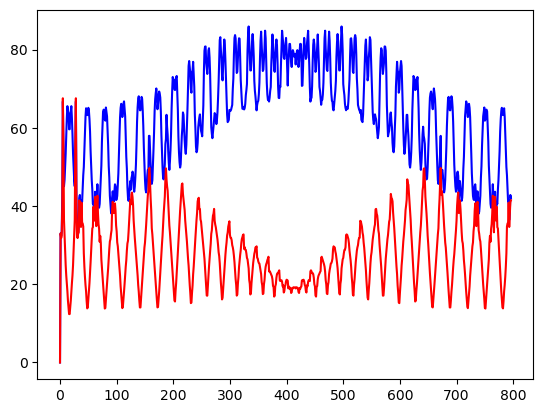

In [4]:
plt.plot(Sigma1, 'b')
plt.plot(Sigma2, 'r')

In [9]:
Sigma1_KK = inv_truncate(Sigma1, r_cut, K, style)
Sigma2_KK = inv_truncate(Sigma2, r_cut, K, style)

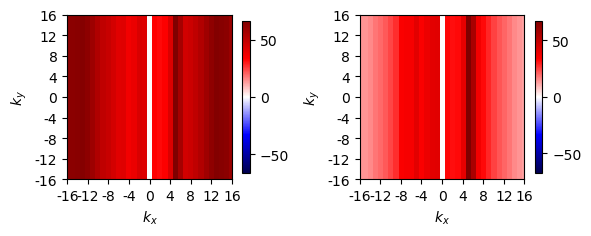

In [10]:
# Plot modes of omega
nrow = 1; ncol = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6,3))

dataplot = np.zeros((K,K,nrow, ncol))
dataplot[:,:,0,0] = Sigma1_KK
dataplot[:,:,0,1] = Sigma2_KK

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx = np.fft.fftfreq(K) * K
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 
r = r_cut

for i in range(nrow):
    for j in range(ncol): 
        n_tick = K//8*2
        maxabs = np.max(abs(dataplot[:, :, i, j]))
        im = axs[j].imshow(dataplot[:, :, i, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
        axs[j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False)) 
        axs[j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))
        axs[j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[j].set_xlim(K//2-r, K//2+r) 
        axs[j].set_ylim(K//2-r, K//2+r)
        axs[j].set_xlabel('$k_x$')
        axs[j].set_ylabel('$k_y$')
        fig.colorbar(im, ax=axs[j], shrink=0.6)

plt.tight_layout()
plt.show()

# 2. DA ($\beta$=22, L=256, N_ens=16)

In [2]:
# load data
data_path = '../qg/QG_DATA_topo40_nu1e-12_beta22_K128_dt2e-3_subs.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    # psi1_k_t_fine = np.transpose(file['psi_1_t_fine'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    s_rate = int(file['s_rate'][()][0,0])
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
# psi1_k_t_fine = psi1_k_t_fine['real'] + 1j * psi1_k_t_fine['imag']
h_hat = np.fft.fft2(topo)
# print('psi1_k_t.shape',psi1_k_t.shape)

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_1_t_fine', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'utz', 'vb']>


In [3]:
# load data of LSM
eigens = np.load('../data/eigens_K128_beta22.npz')
r1 = eigens['r1']
r2 = eigens['r2']
obs = np.load('../data/obs_K128_beta22.npz')
xt = obs['xt']
yt = obs['yt']
L = 256
xt = xt[:L, :]
yt = yt[:L, :]
da_pos = np.load('../data/LSMDA_pos_K128_beta22_tr_L256.npz')
mu_t_lsm = da_pos['mu_t']
R_t_lsm = da_pos['R_t']
da_pos = np.load('../data/LSMDA_cn_pos_K128_beta22_tr.npz')
mu_t_cn = da_pos['mu_t']
R_t_cn = da_pos['R_t']
da_pos = np.load('../data/CGDA_ens16_pos_K128_beta22_tr_L256.npz')
mu_t_cg = da_pos['mu_t']
R_t_cg = da_pos['R_t']
mu_t_mean = np.mean(mu_t_cg, axis=0)
R_t_mean = np.mean(R_t_cg, axis=0) + np.var(mu_t_cg, axis=0)

In [4]:
# truncate parameter
r_cut = 16
style = 'circle'

In [5]:
# Truth of eigenmodes
psi_k_t, tau_k_t = layer2eigen(K, r_cut, r1, r2, psi1_k_t, psi2_k_t, style=style)

#### DA

In [6]:
mu_t_lsm = mu_t_lsm[:, ::s_rate]
mu_t_cn = mu_t_cn[:, ::s_rate]

In [8]:
# reshape flattened variables to two modes matrices
psi_k_pos_lsm, tau_k_pos_lsm = mu2psi(mu_t_lsm, K, r_cut, style)
psi_k_pos_cn, tau_k_pos_cn = mu2psi(mu_t_cn, K, r_cut, style)

In [9]:
N = 200000

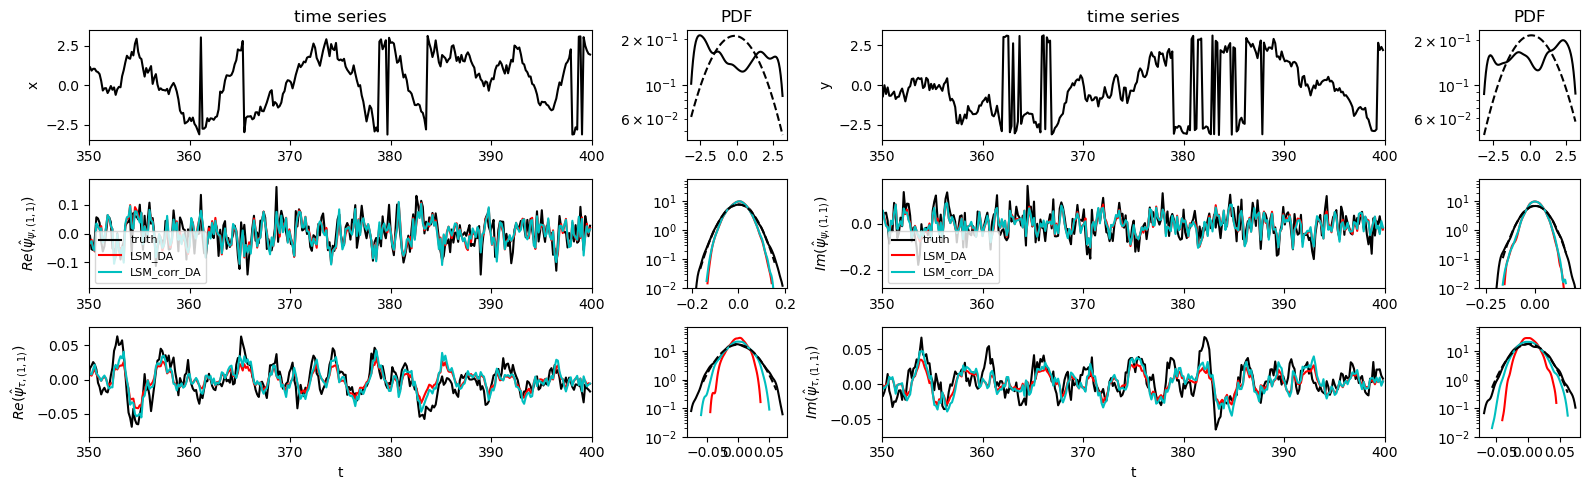

In [16]:
# Plot
sel0 = 0//s_rate; sel1 = N//s_rate # plot time range
ikx = 1; iky = 1 # mode to plot
interv = 10 # plot interval
xlim = (350,400)
ylim = (1e-2, 50)
data1 = [psi_k_t/K**2, psi_k_pos_lsm/K**2, psi_k_pos_cn/K**2]
data2 = [tau_k_t/K**2, tau_k_pos_lsm/K**2, tau_k_pos_cn/K**2]
labels = ['truth', 'LSM_DA', 'LSM_corr_DA']
ylabels = ['\psi', '\tau']
colors = ['k', 'r', 'c']
plot_psi_k_seriespdf(dt*s_rate, sel0, sel1, ikx, iky, interv, xlim, ylim, xt[:,:N:s_rate], yt[:,:N:s_rate], data1, data2, labels, colors)
plt.savefig('./Lagrangian_DA/LSMDA_psi_k_K128_beta22_tr16_L256.png',dpi=100)
plt.show()

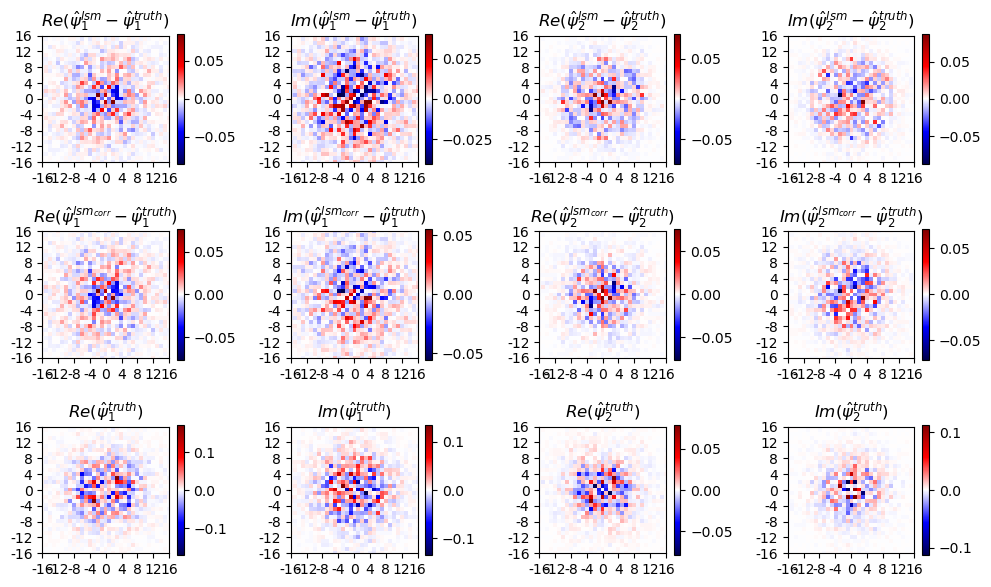

In [17]:
# plot error mode
psi1_k_pos_lsm, psi2_k_pos_lsm = eigen2layer(K,r_cut,r1,r2,psi_k_pos_lsm,tau_k_pos_lsm,style)
psi1_k_pos_cn, psi2_k_pos_cn = eigen2layer(K,r_cut,r1,r2,psi_k_pos_cn,tau_k_pos_cn,style)

nrow, ncol = (3,4)
fig, axs = plt.subplots(nrow, ncol, figsize=(10,6))

dataplot = np.zeros((K,K,nrow,ncol))
dataplot[:,:,0,0] = (psi1_k_pos_lsm[:, :, N//s_rate-1] - psi1_k_t[:, :, N//s_rate-1]).real / K**2
dataplot[:,:,0,1] = (psi1_k_pos_lsm[:, :, N//s_rate-1] - psi1_k_t[:, :, N//s_rate-1]).imag / K**2
dataplot[:,:,1,0] = (psi1_k_pos_cn[:, :, N//s_rate-1] - psi1_k_t[:, :, N//s_rate-1]).real / K**2
dataplot[:,:,1,1] = (psi1_k_pos_cn[:, :, N//s_rate-1] - psi1_k_t[:, :, N//s_rate-1]).imag / K**2
dataplot[:,:,-1,0] = psi1_k_t[:, :, N//s_rate-1].real / K**2
dataplot[:,:,-1,1] = psi1_k_t[:, :, N//s_rate-1].imag / K**2
dataplot[:,:,0,2] = (psi2_k_pos_lsm[:, :, N//s_rate-1] - psi2_k_t[:, :, N//s_rate-1]).real / K**2
dataplot[:,:,0,3] = (psi2_k_pos_lsm[:, :, N//s_rate-1] - psi2_k_t[:, :, N//s_rate-1]).imag / K**2
dataplot[:,:,1,2] = (psi2_k_pos_cn[:, :, N//s_rate-1] - psi2_k_t[:, :, N//s_rate-1]).real / K**2
dataplot[:,:,1,3] = (psi2_k_pos_cn[:, :, N//s_rate-1] - psi2_k_t[:, :, N//s_rate-1]).imag / K**2
dataplot[:,:,-1,2] = psi2_k_t[:, :, N//s_rate-1].real / K**2
dataplot[:,:,-1,3] = psi2_k_t[:, :, N//s_rate-1].imag / K**2

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx = np.fft.fftfreq(K) * K
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 

for i in range(nrow):
    for j in range(ncol):
        n_tick = K//8*2
        maxabs = np.max(abs(dataplot[:, :, i, j]))
        im = axs[i,j].imshow(dataplot[:, :, i, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
        axs[i,j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False)) 
        axs[i,j].set_xticklabels(Kx[::K//n_tick].astype(int))
        axs[i,j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))
        axs[i,j].set_yticklabels(Kx[::K//n_tick].astype(int))
        axs[i,j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_xlim(K//2-r_cut, K//2+r_cut) 
        axs[i,j].set_ylim(K//2-r_cut, K//2+r_cut)
        fig.colorbar(im, ax=axs[i,j])
        
axs[0,0].set_title(f'$Re(\hat{{\psi}}^{{lsm}}_1 - \hat{{\psi}}^{{truth}}_1)$')
axs[0,1].set_title(f'$Im(\hat{{\psi}}^{{lsm}}_1 - \hat{{\psi}}^{{truth}}_1)$')
axs[0,2].set_title(f'$Re(\hat{{\psi}}^{{lsm}}_2 - \hat{{\psi}}^{{truth}}_2)$')
axs[0,3].set_title(f'$Im(\hat{{\psi}}^{{lsm}}_2 - \hat{{\psi}}^{{truth}}_2)$')
axs[1,0].set_title(f'$Re(\hat{{\psi}}^{{lsm_{{corr}}}}_1 - \hat{{\psi}}^{{truth}}_1)$')
axs[1,1].set_title(f'$Im(\hat{{\psi}}^{{lsm_{{corr}}}}_1 - \hat{{\psi}}^{{truth}}_1)$')
axs[1,2].set_title(f'$Re(\hat{{\psi}}^{{lsm_{{corr}}}}_2 - \hat{{\psi}}^{{truth}}_2)$')
axs[1,3].set_title(f'$Im(\hat{{\psi}}^{{lsm_{{corr}}}}_2 - \hat{{\psi}}^{{truth}}_2)$')
axs[-1,0].set_title(f'$Re(\hat{{\psi}}^{{truth}}_1)$')
axs[-1,1].set_title(f'$Im(\hat{{\psi}}^{{truth}}_1)$')
axs[-1,2].set_title(f'$Re(\hat{{\psi}}^{{truth}}_2)$')
axs[-1,3].set_title(f'$Im(\hat{{\psi}}^{{truth}}_2)$')

plt.tight_layout()
plt.savefig('./Lagrangian_DA/LSMDA_err_psi_k_K128_beta22_tr16_L256.png', dpi=100)
plt.show()

In [10]:
psi1_k_pos_lsm, psi2_k_pos_lsm = eigen2layer(K,r_cut,r1,r2,psi_k_pos_lsm,tau_k_pos_lsm,style)
psi1_k_pos_cn, psi2_k_pos_cn = eigen2layer(K,r_cut,r1,r2,psi_k_pos_cn,tau_k_pos_cn,style)
psi2_k_pos_cg = inv_truncate(mu_t_mean, r_cut, K, style)

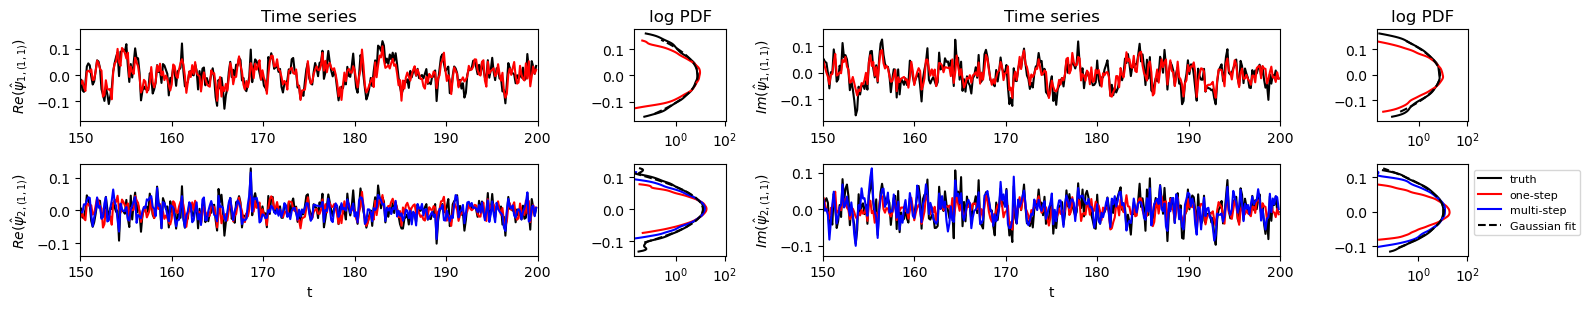

In [12]:
# Plot
sel0 = 0//s_rate; sel1 = 100000//s_rate # plot time range
ikx = 1; iky = 1 # mode to plot
interv = 10 # plot interval
xlim = (150,200)
ylim = (2e-2, 100)
data1 = [psi1_k_t[:,:,12500:]/K**2, psi1_k_pos_lsm[:,:,12500:]/K**2]
data2 = [psi2_k_t[:,:,12500:]/K**2, psi2_k_pos_lsm[:,:,12500:]/K**2, psi2_k_pos_cg/K**2]
labels = ['truth', 'one-step', 'multi-step']
colors = ['k', 'r', 'b']
plot_psi1_k_seriespdf(dt*s_rate, sel0, sel1, ikx, iky, interv, xlim, ylim, xt[:,100000:N:s_rate], yt[:,100000:N:s_rate], data1, data2, labels, colors)
plt.savefig('./Lagrangian_DA/DA_layer_k_K128_beta22_tr16_L256.png',dpi=100)
plt.show()

In [13]:
# ifft to real space
psi1_t = ifftnroll(K, psi1_k_t[:, :, 12500:N//s_rate])
psi2_t = ifftnroll(K, psi2_k_t[:, :, 12500:N//s_rate])
psi1_pos_lsm = ifftnroll(K, psi1_k_pos_lsm[:, :, 12500:N//s_rate])
psi2_pos_lsm = ifftnroll(K, psi2_k_pos_lsm[:, :, 12500:N//s_rate])
psi1_pos_cn = ifftnroll(K, psi1_k_pos_cn[:, :, 12500:N//s_rate])
psi2_pos_cn = ifftnroll(K, psi2_k_pos_cn[:, :, 12500:N//s_rate])
psi2_pos_cg = ifftnroll(K, psi2_k_pos_cg)

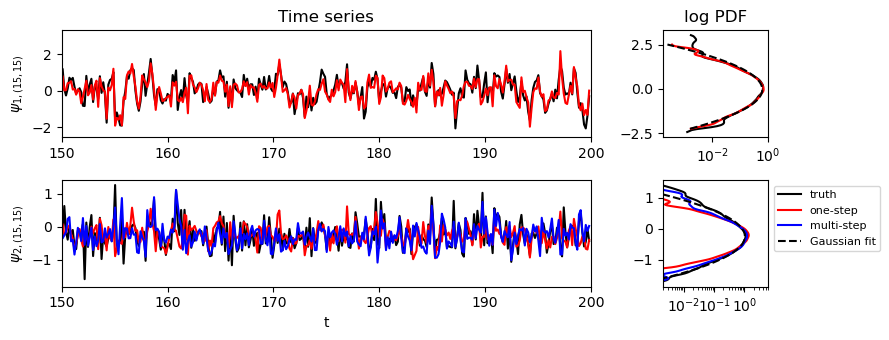

In [14]:
sel0 = 0//(s_rate); sel1 = 100000//(s_rate) # plot time range
xlim = (150,200)
ylim = (2e-3, 5)
ikx = 15; iky = 15 # x,y to plot
interv = 10
data1 = [psi1_t, psi1_pos_lsm]
data2 = [psi2_t, psi2_pos_lsm, psi2_pos_cg]
labels = ['truth', 'one-step','multi-step']
colors = ['k', 'r', 'b']
plot_layer_seriespdf(dt*s_rate, sel0, sel1, ikx, iky, interv, xlim, ylim, data1, data2, labels, colors)
plt.savefig('./Lagrangian_DA/DA_layer_K128_beta22_tr16_L256.png',dpi=100)
plt.show()

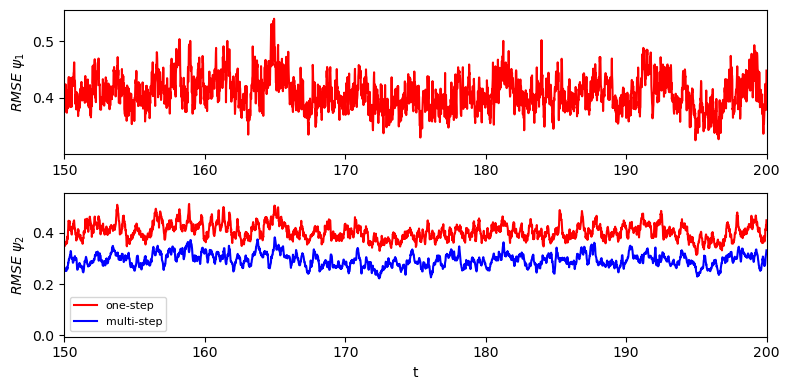

In [15]:
# Plot
rmse1_t_lsm = np.sqrt(np.mean((psi1_pos_lsm - psi1_t)**2, axis=(0,1)))
rmse2_t_lsm = np.sqrt(np.mean((psi2_pos_lsm - psi2_t)**2, axis=(0,1)))
# rmse1_t_cn = np.sqrt(np.mean((psi1_pos_cn - psi1_t)**2, axis=(0,1)))
# rmse2_t_cn = np.sqrt(np.mean((psi2_pos_cn - psi2_t)**2, axis=(0,1)))
rmse2_t_cg = np.sqrt(np.mean((psi2_pos_cg - psi2_t)**2, axis=(0,1)))
data1 = [rmse1_t_lsm]
data2 = [rmse2_t_lsm, rmse2_t_cg]
interv = 1
sel0 = 0//(s_rate); sel1 = 100000//(s_rate) # plot time range
xlim = (150,200)
labels = ['one-step', 'multi-step']
colors = ['r', 'b']
plot_rmses(dt, sel0, sel1, s_rate, interv, xlim, data1, data2, labels, colors)
plt.savefig('./Lagrangian_DA/rmses_ens16_K128_beta22_tr16_real_L256.png',dpi=100)
plt.show()

In [11]:
# RMSE
n_start = 0 # spin up time
rmse1_xy = np.sqrt(np.mean((psi1_pos_lsm[:,:,n_start:] - psi1_t[:,:,n_start:])**2, axis=(0,1)))
rmse2_xy = np.sqrt(np.mean((psi2_pos_lsm[:,:,n_start:] - psi2_t[:,:,n_start:])**2, axis=(0,1)))
rmse1_m = np.mean(rmse1_xy)
rmse2_m = np.mean(rmse2_xy)
print('LSM DA')
print('RMSE(upper layer):', rmse1_m)
print('RMSE(lower layer):', rmse2_m)

rmse1_xy_cn = np.sqrt(np.mean((psi1_pos_cn[:,:,n_start:] - psi1_t[:,:,n_start:])**2, axis=(0,1)))
rmse2_xy_cn = np.sqrt(np.mean((psi2_pos_cn[:,:,n_start:] - psi2_t[:,:,n_start:])**2, axis=(0,1)))
rmse1_m_cn = np.mean(rmse1_xy_cn)
rmse2_m_cn = np.mean(rmse2_xy_cn)
print('LSM DA with correlated noise')
print('RMSE(upper layer):', rmse1_m_cn)
print('RMSE(lower layer):', rmse2_m_cn)

rmse2_xy_cg = np.sqrt(np.mean((psi2_pos_cg[:,:,n_start:] - psi2_t[:,:,n_start:])**2, axis=(0,1)))
rmse2_m_cg = np.mean(rmse2_xy_cg)
print('CG DA')
print('RMSE(lower layer):', rmse2_m_cg)

LSM DA
RMSE(upper layer): 0.4047933072616345
RMSE(lower layer): 0.40049100139845933
LSM DA with correlated noise
RMSE(upper layer): 0.38039246460880394
RMSE(lower layer): 0.3715463846967803
CG DA
RMSE(lower layer): 0.2909959489565423


###### Snapshots of PV flow field

In [26]:
psi1_k_pos_lsm, psi2_k_pos_lsm = eigen2layer(K,r_cut,r1,r2,psi_k_pos_lsm,tau_k_pos_lsm,style)
psi2_k_pos_cg = inv_truncate(mu_t_mean, r_cut, K, style)

In [16]:
N = 100000
q1_k_t, q2_k_t = psi2q(psi1_k_t[:, :, -N//s_rate:], psi2_k_t[:, :, -N//s_rate:], kd, h_hat)
q1_k_t_lsm, q2_k_t_lsm = psi2q(psi1_k_pos_lsm[:, :, -N//s_rate:], psi2_k_pos_lsm[:, :, -N//s_rate:], kd, h_hat)
q1_k_t_cn, q2_k_t_cn = psi2q(psi1_k_pos_cn[:, :, -N//s_rate:], psi2_k_pos_cn[:, :, -N//s_rate:], kd, h_hat)
q1_k_t_cg, q2_k_t_cg = psi2q(psi1_k_pos_lsm[:, :, -N//s_rate:], psi2_k_pos_cg[:, :, -N//s_rate:], kd, h_hat)

In [17]:
# ifft to real space
n_t = -5500
q1_k_t = inv_truncate(truncate(q1_k_t[:, :, n_t], r_cut, style)[:,None], r_cut, K, style)
q2_k_t = inv_truncate(truncate(q2_k_t[:, :, n_t], r_cut, style)[:,None], r_cut, K, style)
q1_t = ifftnroll(K, q1_k_t)[:,:,0]
q2_t = ifftnroll(K, q2_k_t)[:,:,0]
q1_t_lsm = ifftnroll(K, q1_k_t_lsm[:, :, n_t])
q2_t_lsm = ifftnroll(K, q2_k_t_lsm[:, :, n_t])
q1_t_cn = ifftnroll(K, q1_k_t_cn[:, :, n_t])
q2_t_cn = ifftnroll(K, q2_k_t_cn[:, :, n_t])
q1_t_cg = ifftnroll(K, q1_k_t_cg[:, :, n_t])
q2_t_cg = ifftnroll(K, q2_k_t_cg[:, :, n_t])

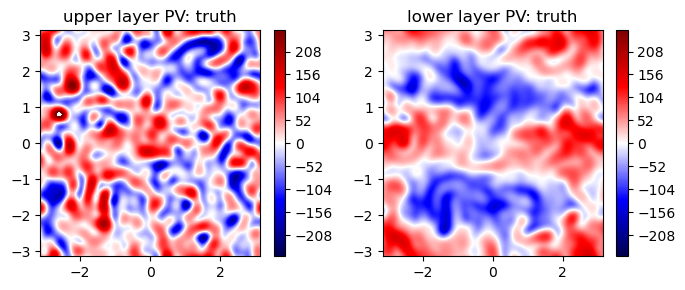

In [20]:
colorlim=(256, 256)
plot_contour_fields(q1_t, q2_t, 'truth', colorlim)
plt.savefig('./Lagrangian_DA/truth_q_beta22.png')
plt.show()

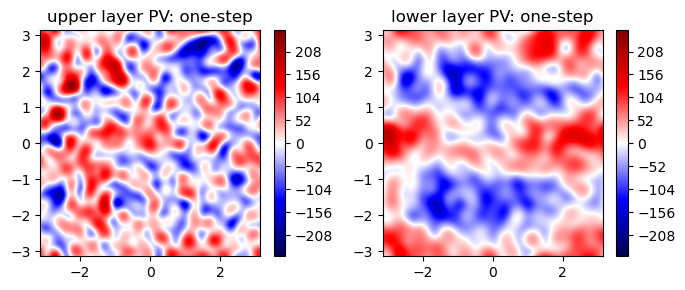

In [20]:
colorlim=(256, 256)
plot_contour_fields(q1_t_lsm, q2_t_lsm, 'one-step', colorlim)
plt.savefig('./Lagrangian_DA/LSM_q_beta22_L256.png')
plt.show()

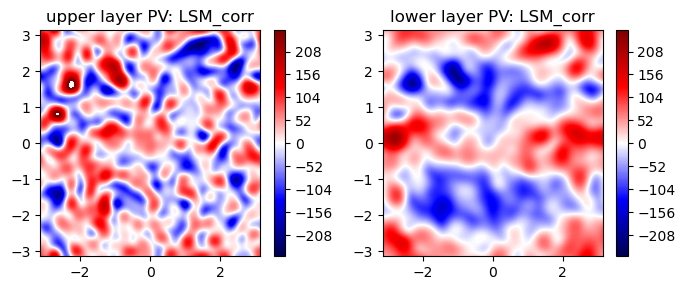

In [31]:
colorlim=(256, 256)
plot_contour_fields(q1_t_cn, q2_t_cn, 'LSM_corr', colorlim)
plt.savefig('./Lagrangian_DA/LSMcorr_q_beta22_L256.png')
plt.show()

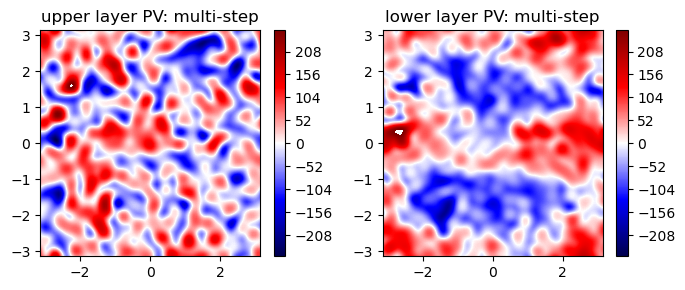

In [19]:
plot_contour_fields(q1_t_cg, q2_t_cg, 'multi-step', colorlim)
plt.savefig('./Lagrangian_DA/CGens_q_beta22_L256.png')
plt.show()

#### Non-Gaussian case

sel0 = 364x500, run N=2000 steps, examine n_t = int(2.3/4*500)

In [23]:
# load data
da_pos = np.load('../data/LSMDA_pos_K128_beta22_tr_L256.npz')
mu_t_lsm = da_pos['mu_t']
R_t_lsm = da_pos['R_t']
da_pos = np.load('../data/CGDA_ens512_pos_K128_beta22_tr_L256.npz')
mu_t = da_pos['mu_t']
R_t = da_pos['R_t']
mu_t_mean = np.mean(mu_t, axis=0)
R_t_mean = np.mean(R_t, axis=0) + np.var(mu_t, axis=0)

N_s = 512
N = 2000
n_t = int(2.3/4*250)

In [24]:
psi_k_pos_lsm, tau_k_pos_lsm = mu2psi(mu_t_lsm, K, r_cut, style)
psi1_k_pos_lsm, psi2_k_pos_lsm= eigen2layer(K,r_cut,r1,r2,psi_k_pos_lsm[:, :, sel0:sel0+N],tau_k_pos_lsm[:, :, sel0:sel0+N],style)
psi2_k_pos_lsm = psi2_k_pos_lsm[:, :, ::s_rate]

In [27]:
psi2_pos_lsm = ifftnroll(K, psi2_k_pos_lsm[:, :, n_t])
_, R_psi2_k_lsm = R2layer(R_t_lsm[:, sel0:sel0+N:s_rate], K, r_cut, r1, r2, style)
R_psi2_k_pos_lsm = R_psi2_k_lsm[:, n_t]
R_psi2_pos_lsm = ifft2_var(K, R_psi2_k_pos_lsm.real, R_psi2_k_pos_lsm.imag, r_cut)

psi2_k_pos_cg = np.zeros((N_s, K, K), dtype=complex)
psi2_pos_cg = np.zeros((N_s, K, K))
for n in range(N_s):
    psi2_k_pos_cg[n, :, :] = inv_truncate(mu_t[n, :, n_t][:, None] ,r_cut, K, style='circle')[:,:,0]
    psi2_pos_cg[n, :, :] = ifftnroll(K, psi2_k_pos_cg[n, :, :])
R_psi2_pos_cg = np.zeros((N_s, K, K))
for n in range(N_s):
    # print(n)
    R_psi2_k_pos_cg = R_t[n, :, n_t]
    R_psi2_pos_cg[n, :, :] = ifft2_var(K, R_psi2_k_pos_cg.real, R_psi2_k_pos_cg.imag, r_cut)

psi2_t = ifftnroll(K, psi2_k_t[:, :, sel0//s_rate+n_t])

In [102]:
# Call the function with appropriate parameters
plot_mog_animation(N_s=512, K=128, psi2_pos_cg=psi2_pos_cg, psi2_pos_lsm=psi2_pos_lsm, 
                   R_psi2_pos_cg=R_psi2_pos_cg, R_psi2_pos_lsm=R_psi2_pos_lsm, psi2_t=psi2_t, 
                   xlim=(-3.5, 3.5), smoothing_sigma=.1, figsize=(4.5, 4), gif_name="mog_animation.gif")


/grad/wang3262/miniconda3/envs/py/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:1988: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [77]:
skewness_array = np.zeros((K,K))
kurtosis_array = np.zeros((K,K))
for ix in range(K):
    for iy in range(K):
        skewness, kurt = calculate_skewness_kurtosis(ix, iy, N_s, K, psi2_pos_cg, R_psi2_pos_cg)
        skewness_array[iy, ix] = skewness
        kurtosis_array[iy, ix] = kurt

np.savez('skewkurt.npz', skewness_array=skewness_array, kurtosis_array=kurtosis_array)

/tmp/ipykernel_1140455/1780325521.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  component_samples = np.random.normal(means[i], std_devs[i], num_samples // N_s)


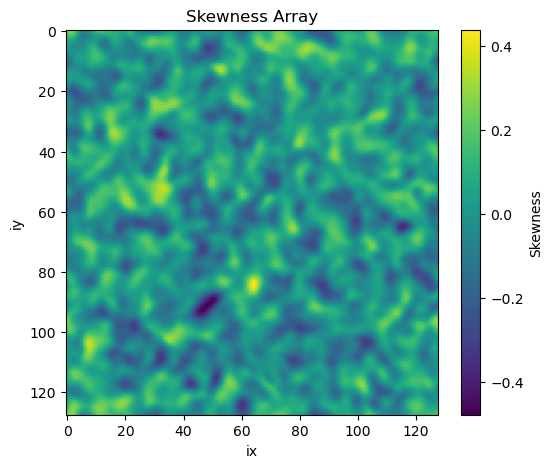

In [78]:
plt.figure(figsize=(6, 5))
plt.imshow(skewness_array, cmap='viridis', aspect='auto')
plt.colorbar(label='Skewness')
plt.title("Skewness Array")
plt.xlabel("ix")
plt.ylabel("iy")
plt.show()

In [120]:
np.where(abs(skewness_array) ==np.max(abs(skewness_array)))

(array([90]), array([49]))

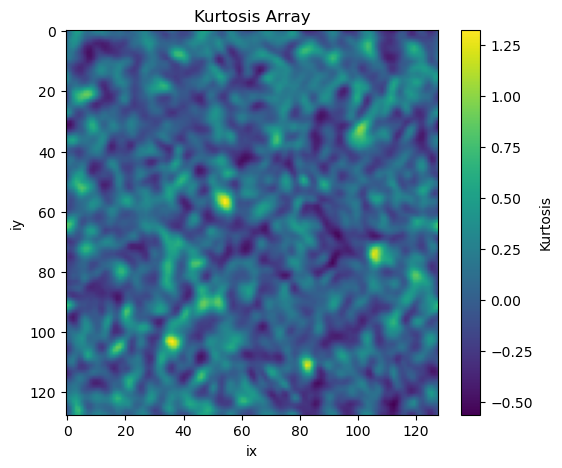

In [79]:
plt.figure(figsize=(6, 5))
plt.imshow(kurtosis_array, cmap='viridis', aspect='auto')
plt.colorbar(label='Kurtosis')
plt.title("Kurtosis Array")
plt.xlabel("ix")
plt.ylabel("iy")
plt.show()

In [139]:
np.where(abs(kurtosis_array) ==np.max(abs(kurtosis_array)))

(array([57]), array([54]))

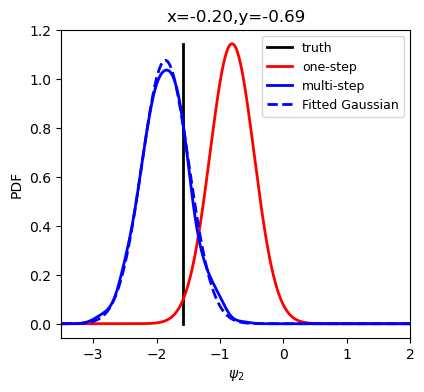

skewness 0.049176542650733006
kurtosis 0.10356809807328293


In [44]:
# plot Gaussian mixture
ix = 60; iy = 50 # x,y to plot
plot_mog(ix, iy, N_s, K, psi2_pos_cg, psi2_pos_lsm, R_psi2_pos_cg, R_psi2_pos_lsm, psi2_t, xlim=(-3.5, 2), smoothing_factor=.3, figsize=(4.5,4), smoother='gaussian_kde')
plt.savefig('./Lagrangian_DA/mixgaussian0.png',dpi=100)
plt.show()

skewness, kurt = calculate_skewness_kurtosis(ix, iy, N_s, K, psi2_pos_cg.real, R_psi2_pos_cg)
print('skewness', skewness)
print('kurtosis', kurt)

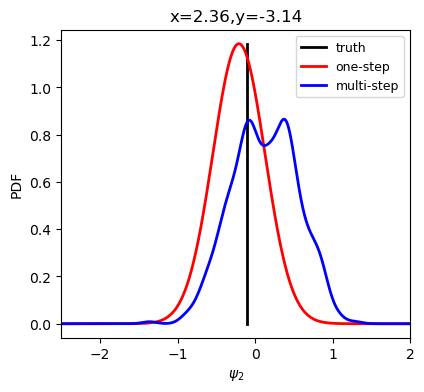

skewness -0.08222536583305325
kurtosis -0.35451276890531425


In [29]:
# plot Gaussian mixture
ix = 112; iy = 0 # x,y to plot
plot_mog(ix, iy, N_s, K, psi2_pos_cg, psi2_pos_lsm, R_psi2_pos_cg, R_psi2_pos_lsm, psi2_t, xlim=(-2.5, 2), smoothing_factor=.2, figsize=(4.5,4), smoother='gaussian_kde')
plt.savefig('./Lagrangian_DA/mixgaussian1.png',dpi=100)
plt.show()

skewness, kurt = calculate_skewness_kurtosis(ix, iy, N_s, K, psi2_pos_cg.real, R_psi2_pos_cg)
print('skewness', skewness)
print('kurtosis', kurt)

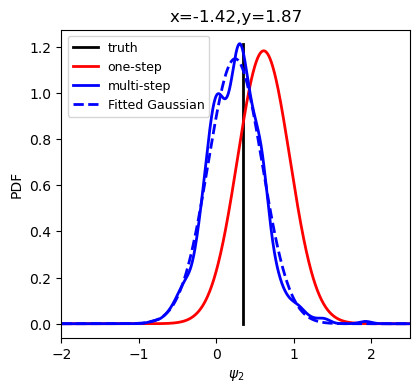

skewness 0.31954398063304285
kurtosis 1.133152873262226


In [32]:
# plot Gaussian mixture
ix = 35; iy = 102 # x,y to plot
plot_mog(ix, iy, N_s, K, psi2_pos_cg, psi2_pos_lsm, R_psi2_pos_cg, R_psi2_pos_lsm, psi2_t, xlim=(-2, 2.5), smoothing_factor=.2, figsize=(4.5,4), smoother='gaussian_kde')
plt.savefig('./Lagrangian_DA/mixgaussian2.png',dpi=100)
plt.show()

skewness, kurt = calculate_skewness_kurtosis(ix, iy, N_s, K, psi2_pos_cg.real, R_psi2_pos_cg)
print('skewness', skewness)
print('kurtosis', kurt)

#### constant covariance 

In [2]:
da_pos = np.load('../data/CGDA_ens16_pos_K128_beta22_tr_L256.npz')
mu_t_cg = da_pos['mu_t']
R_t_cg = da_pos['R_t']
R_t_cg.shape

(16, 797, 12500)

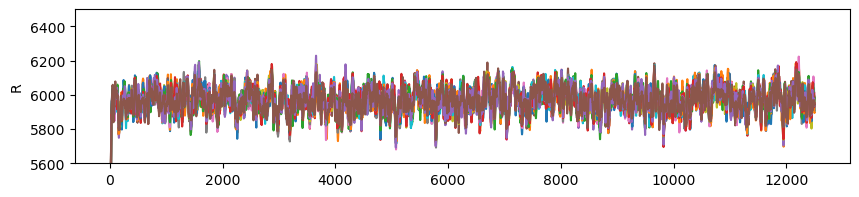

In [9]:
k = 1
plt.figure(figsize=(10, 2))  # Set the figure size

for n in range(16):
    plt.plot(R_t_cg[n, k, :])
plt.ylabel('R')
plt.ylim(5600,6500)
plt.show()

In [17]:
R0 = np.mean(np.mean(R_t_cg, axis=0), axis=1)
np.save('../data/R0_cgda_e16_b22_L256.npy', R0)

In [157]:
# load data of LSM
eigens = np.load('../data/eigens_K128_beta22.npz')
r1 = eigens['r1']
r2 = eigens['r2']
obs = np.load('../data/obs_K128_beta22.npz')
xt = obs['xt']
yt = obs['yt']
L = 256
xt = xt[:L, :]
yt = yt[:L, :]
da_pos = np.load('../data/LSMDA_pos_K128_beta22_tr_L256.npz')
mu_t_lsm = da_pos['mu_t']
R_t_lsm = da_pos['R_t']
da_pos = np.load('../data/LSMDA_cn_pos_K128_beta22_tr.npz')
mu_t_cn = da_pos['mu_t']
R_t_cn = da_pos['R_t']
psi1_k_pos_lsm.shape
da_pos = np.load('../data/CGDA_ens16_pos_K128_beta22_tr_L256.npz')
mu_t_cg = da_pos['mu_t']
R_t_cg = da_pos['R_t']
mu_t_mean = np.mean(mu_t_cg, axis=0)
R_t_mean = np.mean(R_t_cg, axis=0) + np.var(mu_t_cg, axis=0)
da_pos = np.load('../data/CGDA_ens16_pos_K128_beta22_tr_L256_constR.npz')
mu_t_cg1 = da_pos['mu_t']
R_t_cg1 = da_pos['R_t']
mu_t_mean1 = np.mean(mu_t_cg1, axis=0)
R_t_mean1 = np.mean(R_t_cg1, axis=0) + np.var(mu_t_cg1, axis=0)

In [161]:
# truncate parameter
r_cut = 16
style = 'circle'
N = 200000

In [162]:
mu_t_lsm = mu_t_lsm[:, ::s_rate]
mu_t_lsm.shape

(1594, 25000)

In [164]:
psi_k_pos_lsm, tau_k_pos_lsm = mu2psi(mu_t_lsm, K, r_cut, style)
psi_k_pos_cn, tau_k_pos_cn = mu2psi(mu_t_cn, K, r_cut, style)

psi1_k_pos_lsm, psi2_k_pos_lsm = eigen2layer(K,r_cut,r1,r2,psi_k_pos_lsm,tau_k_pos_lsm,style)
psi1_k_pos_cn, psi2_k_pos_cn = eigen2layer(K,r_cut,r1,r2,psi_k_pos_cn,tau_k_pos_cn,style)
psi2_k_pos_cg = inv_truncate(mu_t_mean, r_cut, K, style)
psi2_k_pos_cg1 = inv_truncate(mu_t_mean1, r_cut, K, style)

In [166]:
# ifft to real space
psi1_t = ifftnroll(K, psi1_k_t[:, :, 12500:N//s_rate])
psi2_t = ifftnroll(K, psi2_k_t[:, :, 12500:N//s_rate])
psi1_pos_lsm = ifftnroll(K, psi1_k_pos_lsm[:, :, 12500:N//s_rate])
psi2_pos_lsm = ifftnroll(K, psi2_k_pos_lsm[:, :, 12500:N//s_rate])
psi1_pos_cn = ifftnroll(K, psi1_k_pos_cn[:, :, 12500:N//s_rate])
psi2_pos_cn = ifftnroll(K, psi2_k_pos_cn[:, :, 12500:N//s_rate])
psi2_pos_cg = ifftnroll(K, psi2_k_pos_cg)
psi2_pos_cg1 = ifftnroll(K, psi2_k_pos_cg1)

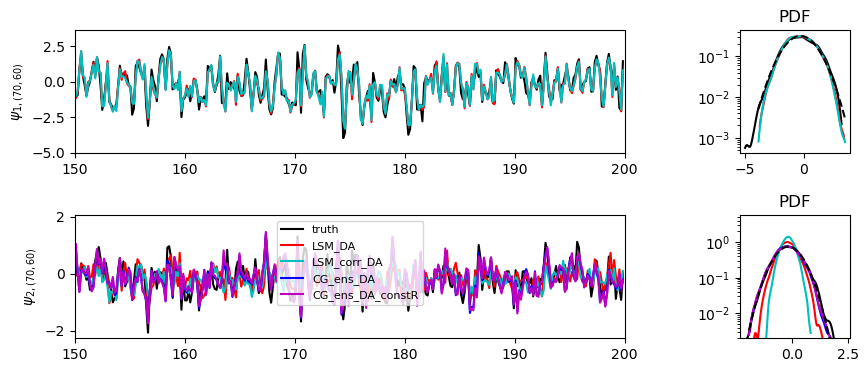

In [175]:
sel0 = 0//(s_rate); sel1 = 100000//(s_rate) # plot time range
xlim = (150,200)
ylim = (2e-3, 5)
ikx = 70; iky = 60 # x,y to plot
interv = 10
data1 = [psi1_t, psi1_pos_lsm, psi1_pos_cn]
data2 = [psi2_t, psi2_pos_lsm, psi2_pos_cn, psi2_pos_cg, psi2_pos_cg1]
labels = ['truth', 'LSM_DA', 'LSM_corr_DA', 'CG_ens_DA', 'CG_ens_DA_constR']
colors = ['k', 'r', 'c', 'b', 'm']
plot_layer_seriespdf(dt*s_rate, sel0, sel1, ikx, iky, interv, xlim, ylim, data1, data2, labels, colors)
plt.savefig('./Lagrangian_DA/DA_layer_K128_beta22_tr16_L256_constR.png',dpi=100)
plt.show()

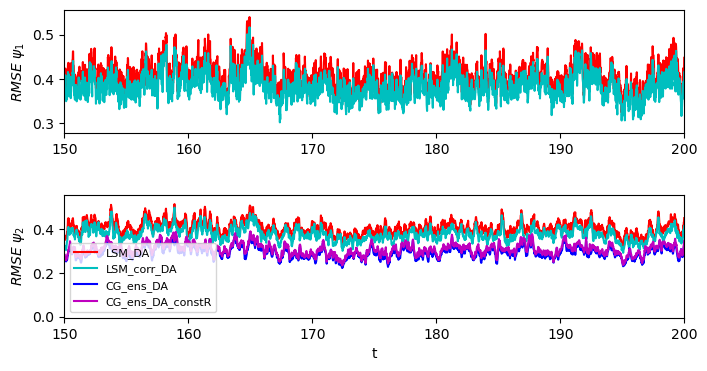

In [177]:
# Plot
rmse1_t_lsm = np.sqrt(np.mean((psi1_pos_lsm - psi1_t)**2, axis=(0,1)))
rmse2_t_lsm = np.sqrt(np.mean((psi2_pos_lsm - psi2_t)**2, axis=(0,1)))
rmse1_t_cn = np.sqrt(np.mean((psi1_pos_cn - psi1_t)**2, axis=(0,1)))
rmse2_t_cn = np.sqrt(np.mean((psi2_pos_cn - psi2_t)**2, axis=(0,1)))
rmse2_t_cg = np.sqrt(np.mean((psi2_pos_cg - psi2_t)**2, axis=(0,1)))
rmse2_t_cg1 = np.sqrt(np.mean((psi2_pos_cg1 - psi2_t)**2, axis=(0,1)))
data1 = [rmse1_t_lsm, rmse1_t_cn]
data2 = [rmse2_t_lsm, rmse2_t_cn, rmse2_t_cg, rmse2_t_cg1]
interv = 1
sel0 = 0//(s_rate); sel1 = 100000//(s_rate) # plot time range
xlim = (150,200)
labels = ['LSM_DA', 'LSM_corr_DA', 'CG_ens_DA', 'CG_ens_DA_constR']
colors = ['r', 'c', 'b', 'm']
plot_rmses(dt, sel0, sel1, s_rate, interv, xlim, data1, data2, labels, colors)
plt.savefig('./Lagrangian_DA/rmses_ens16_K128_beta22_tr16_real_L256_constR.png',dpi=100)
plt.show()

In [38]:
# RMSE
n_start = 0 # spin up time
rmse1_xy = np.sqrt(np.mean((psi1_pos_lsm[:,:,n_start:] - psi1_t[:,:,n_start:])**2, axis=(0,1)))
rmse2_xy = np.sqrt(np.mean((psi2_pos_lsm[:,:,n_start:] - psi2_t[:,:,n_start:])**2, axis=(0,1)))
rmse1_m = np.mean(rmse1_xy)
rmse2_m = np.mean(rmse2_xy)
print('LSM DA')
print('RMSE(upper layer):', rmse1_m)
print('RMSE(lower layer):', rmse2_m)

rmse1_xy_cn = np.sqrt(np.mean((psi1_pos_cn[:,:,n_start:] - psi1_t[:,:,n_start:])**2, axis=(0,1)))
rmse2_xy_cn = np.sqrt(np.mean((psi2_pos_cn[:,:,n_start:] - psi2_t[:,:,n_start:])**2, axis=(0,1)))
rmse1_m_cn = np.mean(rmse1_xy_cn)
rmse2_m_cn = np.mean(rmse2_xy_cn)
print('LSM DA with correlated noise')
print('RMSE(upper layer):', rmse1_m_cn)
print('RMSE(lower layer):', rmse2_m_cn)

rmse2_xy_cg = np.sqrt(np.mean((psi2_pos_cg[:,:,n_start:] - psi2_t[:,:,n_start:])**2, axis=(0,1)))
rmse2_m_cg = np.mean(rmse2_xy_cg)
print('CG DA')
print('RMSE(lower layer):', rmse2_m_cg)

rmse2_xy_cg1 = np.sqrt(np.mean((psi2_pos_cg1[:,:,n_start:] - psi2_t[:,:,n_start:])**2, axis=(0,1)))
rmse2_m_cg1 = np.mean(rmse2_xy_cg1)
print('CG DA with const R')
print('RMSE(lower layer):', rmse2_m_cg1)

LSM DA
RMSE(upper layer): 0.4047933072616345
RMSE(lower layer): 0.40049100139845933
LSM DA with correlated noise
RMSE(upper layer): 0.38039246460880394
RMSE(lower layer): 0.3715463846967803
CG DA
RMSE(lower layer): 0.2909959489565423
CG DA with const R
RMSE(lower layer): 0.3032573846180688


# 3. Sensitivity Experiments

## 3.1 Regimes

In [229]:
q1_k_t, q2_k_t = psi2q(psi1_k_t[:, :, -1][:,:,None], psi2_k_t[:, :, -1][:,:,None], kd, h_hat)
q1_t = ifftnroll(K, q1_k_t)[:,:,0]
q2_t = ifftnroll(K, q2_k_t)[:,:,0]

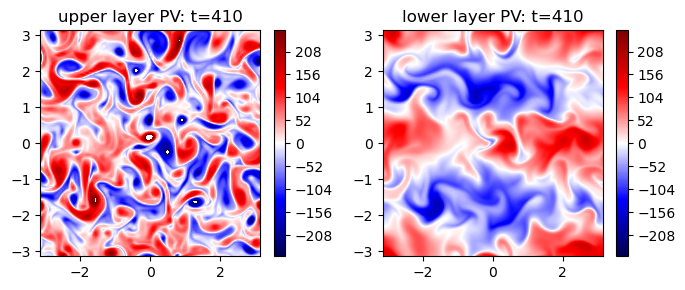

In [227]:
colorlim=(256, 256)
plot_contour_fields(q1_t, q2_t, 't=410', colorlim)
plt.savefig('./Lagrangian_DA/truth_q_beta22_fullK.png')
plt.show()

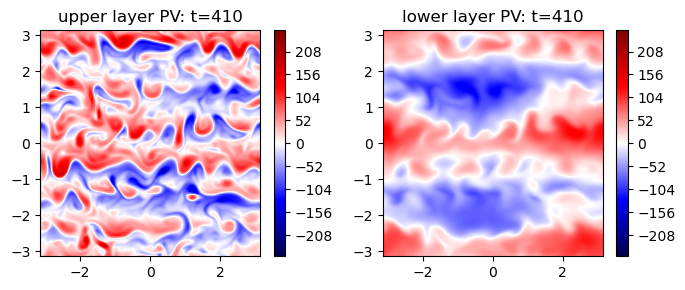

In [230]:
colorlim=(256, 256)
plot_contour_fields(q1_t, q2_t, 't=410', colorlim)
plt.savefig('./Lagrangian_DA/truth_q_beta111_fullK.png')
plt.show()

In [2]:
# load data
data_path = '../qg/QG_DATA_topo40_nu1e-12_beta111_K128_dt2e-3_subs.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    # psi1_k_t_fine = np.transpose(file['psi_1_t_fine'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    s_rate = int(file['s_rate'][()][0,0])
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
# psi1_k_t_fine = psi1_k_t_fine['real'] + 1j * psi1_k_t_fine['imag']
h_hat = np.fft.fft2(topo)
# print('psi1_k_t.shape',psi1_k_t.shape)

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_1_t_fine', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'utz', 'vb']>


In [3]:
# load data of LSM
eigens = np.load('../data/eigens_K128_beta111.npz')
r1 = eigens['r1']
r2 = eigens['r2']
obs = np.load('../data/obs_K128_beta111.npz')
xt = obs['xt']
yt = obs['yt']
sigma_xy = obs['sigma_xy']
L = 256
xt = xt[:L, :]
yt = yt[:L, :]
da_pos = np.load('../data/LSMDA_pos_K128_beta111_tr_L256.npz')
mu_t_lsm = da_pos['mu_t']
R_t_lsm = da_pos['R_t']
da_pos = np.load('../data/CGDA_ens16_pos_K128_beta111_tr_L256.npz')
mu_t_cg = da_pos['mu_t']
R_t_cg = da_pos['R_t']
mu_t_mean = np.mean(mu_t_cg, axis=0)
R_t_mean = np.mean(R_t_cg, axis=0) + np.var(mu_t_cg, axis=0)

In [4]:
# truncate parameter
r_cut = 16
style = 'circle'

In [5]:
# Truth of eigenmodes
psi_k_t, tau_k_t = layer2eigen(K, r_cut, r1, r2, psi1_k_t, psi2_k_t, style=style)

In [5]:
mu_t_lsm = mu_t_lsm[:, ::s_rate]
mu_t_lsm.shape

(1594, 25000)

In [7]:
# reshape flattened variables to two modes matrices
psi_k_pos_lsm, tau_k_pos_lsm = mu2psi(mu_t_lsm, K, r_cut, style)

In [6]:
N = 200000

In [8]:
psi1_k_pos_lsm, psi2_k_pos_lsm = eigen2layer(K,r_cut,r1,r2,psi_k_pos_lsm,tau_k_pos_lsm,style)
# psi1_k_pos_cn, psi2_k_pos_cn = eigen2layer(K,r_cut,r1,r2,psi_k_pos_cn,tau_k_pos_cn,style)
psi2_k_pos_cg = inv_truncate(mu_t_mean, r_cut, K, style)

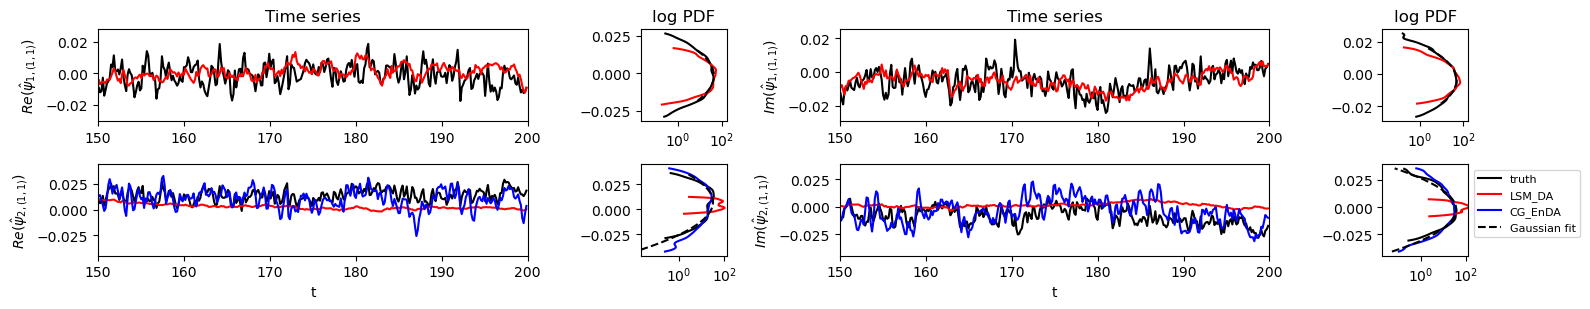

In [10]:
# Plot
sel0 = 0//s_rate; sel1 = 100000//s_rate # plot time range
ikx = 1; iky = 1 # mode to plot
interv = 10 # plot interval
xlim = (150,200)
ylim = (2e-2, 100)
data1 = [psi1_k_t[:,:,12500:]/K**2, psi1_k_pos_lsm[:,:,12500:]/K**2]
data2 = [psi2_k_t[:,:,12500:]/K**2, psi2_k_pos_lsm[:,:,12500:]/K**2, psi2_k_pos_cg/K**2]
labels = ['truth', 'LSM_DA', 'CG_EnDA']
colors = ['k', 'r', 'b']
plot_psi1_k_seriespdf(dt*s_rate, sel0, sel1, ikx, iky, interv, xlim, ylim, xt[:,100000:N:s_rate], yt[:,100000:N:s_rate], data1, data2, labels, colors)
plt.savefig('./Lagrangian_DA/DA_layer_k_K128_beta111_tr16_L256.png',dpi=100)
plt.show()

In [9]:
# ifft to real space
psi1_t = ifftnroll(K, psi1_k_t[:, :, 12500:N//s_rate])
psi2_t = ifftnroll(K, psi2_k_t[:, :, 12500:N//s_rate])
psi1_pos_lsm = ifftnroll(K, psi1_k_pos_lsm[:, :, 12500:N//s_rate])
psi2_pos_lsm = ifftnroll(K, psi2_k_pos_lsm[:, :, 12500:N//s_rate])
psi2_pos_cg = ifftnroll(K, psi2_k_pos_cg)

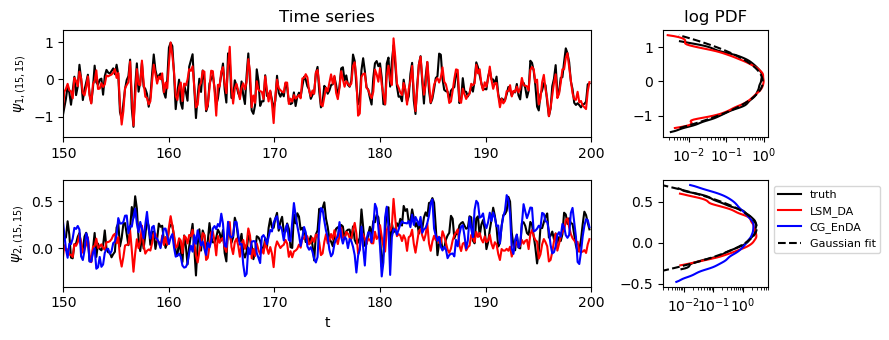

In [13]:
sel0 = 0//(s_rate); sel1 = 100000//(s_rate) # plot time range
xlim = (150,200)
ylim = (2e-3, 5)
ikx = 15; iky = 15 # x,y to plot
interv = 10
data1 = [psi1_t, psi1_pos_lsm]
data2 = [psi2_t, psi2_pos_lsm, psi2_pos_cg]
labels = ['truth', 'LSM_DA','CG_EnDA']
colors = ['k', 'r', 'b']
plot_layer_seriespdf(dt*s_rate, sel0, sel1, ikx, iky, interv, xlim, ylim, data1, data2, labels, colors)
plt.savefig('./Lagrangian_DA/DA_layer_K128_beta111_tr16_L256.png',dpi=100)
plt.show()

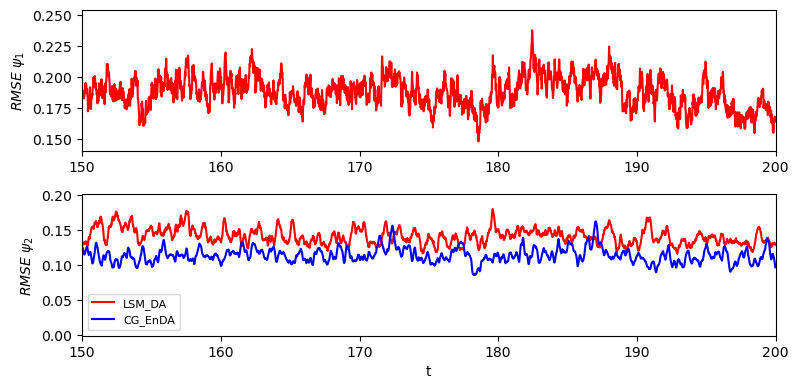

In [17]:
# Plot
rmse1_t_lsm = np.sqrt(np.mean((psi1_pos_lsm - psi1_t)**2, axis=(0,1)))
rmse2_t_lsm = np.sqrt(np.mean((psi2_pos_lsm - psi2_t)**2, axis=(0,1)))
rmse2_t_cg = np.sqrt(np.mean((psi2_pos_cg - psi2_t)**2, axis=(0,1)))
data1 = [rmse1_t_lsm]
data2 = [rmse2_t_lsm, rmse2_t_cg]
interv = 1
sel0 = 0//(s_rate); sel1 = 100000//(s_rate) # plot time range
xlim = (150,200)
labels = ['LSM_DA', 'CG_EnDA']
colors = ['r', 'b']
plot_rmses(dt, sel0, sel1, s_rate, interv, xlim, data1, data2, labels, colors)
plt.savefig('./Lagrangian_DA/rmses_ens16_K128_beta111_tr16_real_L256.png',dpi=100)
plt.show()

In [10]:
# RMSE
n_start = 0 # spin up time
rmse1_xy = np.sqrt(np.mean((psi1_pos_lsm[:,:,n_start:] - psi1_t[:,:,n_start:])**2, axis=(0,1)))
rmse2_xy = np.sqrt(np.mean((psi2_pos_lsm[:,:,n_start:] - psi2_t[:,:,n_start:])**2, axis=(0,1)))
rmse1_m = np.mean(rmse1_xy)
rmse2_m = np.mean(rmse2_xy)
print('LSM DA')
print('RMSE(upper layer):', rmse1_m)
print('RMSE(lower layer):', rmse2_m)

rmse2_xy_cg = np.sqrt(np.mean((psi2_pos_cg[:,:,n_start:] - psi2_t[:,:,n_start:])**2, axis=(0,1)))
rmse2_m_cg = np.mean(rmse2_xy_cg)
print('CG DA')
print('RMSE(lower layer):', rmse2_m_cg)

LSM DA
RMSE(upper layer): 0.18698416445271349
RMSE(lower layer): 0.13737980546773199
CG DA
RMSE(lower layer): 0.11302340239744295


## 3.2 Observation density $L$

In [6]:
# load data
data_path = '../qg/QG_DATA_topo40_nu1e-12_beta22_K128_dt2e-3_subs.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    # psi1_k_t_fine = np.transpose(file['psi_1_t_fine'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    s_rate = int(file['s_rate'][()][0,0])
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
# psi1_k_t_fine = psi1_k_t_fine['real'] + 1j * psi1_k_t_fine['imag']
h_hat = np.fft.fft2(topo)
# print('psi1_k_t.shape',psi1_k_t.shape)

eigens = np.load('../data/eigens_K128_beta22.npz')
r1 = eigens['r1']
r2 = eigens['r2']

In [7]:
# truncate parameter
r_cut = 16
style = 'circle'

In [19]:
# transformation
N = 100000
psi1_t = ifftnroll(K, psi1_k_t[:, :, -N//s_rate:])
psi2_t = ifftnroll(K, psi2_k_t[:, :, -N//s_rate:])
# RMSE
n_start = 0 # spin up time

Ls = [16, 64, 256]
rmses2_m_cg = []
rmses2_m_lsm = []
for L in Ls:
    da_pos = np.load('../data/LSMDA_pos_K128_beta22_tr_L{:d}.npz'.format(L))
    mu_t_lsm = da_pos['mu_t']
    R_t_lsm = da_pos['R_t']
    mu_t_lsm = mu_t_lsm[:, ::s_rate]
    psi_k_pos_lsm, tau_k_pos_lsm = mu2psi(mu_t_lsm, K, r_cut, style)
    psi1_k_pos_lsm, psi2_k_pos_lsm = eigen2layer(K,r_cut,r1,r2,psi_k_pos_lsm,tau_k_pos_lsm,style)
    psi2_pos_lsm = ifftnroll(K, psi2_k_pos_lsm[:, :, -N//s_rate:])
    rmse2_xy_lsm = np.sqrt(np.mean((psi2_pos_lsm[:,:,n_start:] - psi2_t[:,:,n_start:])**2, axis=(0,1)))
    rmse2_m_lsm = np.mean(rmse2_xy_lsm)
    rmses2_m_lsm.append(rmse2_m_lsm)
    
    da_pos = np.load('../data/CGDA_ens16_pos_K128_beta22_tr_L{:d}.npz'.format(L))
    mu_t_cg = da_pos['mu_t']
    R_t_cg = da_pos['R_t']
    mu_t_mean = np.mean(mu_t_cg, axis=0)
    psi2_k_pos_cg = inv_truncate(mu_t_mean, r_cut, K, style)
    psi2_pos_cg = ifftnroll(K, psi2_k_pos_cg)
    rmse2_xy_cg = np.sqrt(np.mean((psi2_pos_cg[:,:,n_start:] - psi2_t[:,:,n_start:])**2, axis=(0,1)))
    rmse2_m_cg = np.mean(rmse2_xy_cg)
    rmses2_m_cg.append(rmse2_m_cg)

In [26]:
rmses2_m_cg=rmses2_m_cg[:3]
rmses2_m_lsm=rmses2_m_lsm[:3]

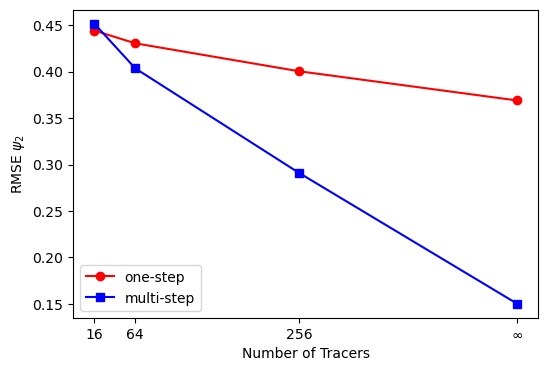

In [32]:
# Create the plot
Ls = [16, 64, 256, 512]
rmses2_m_lsm.append(0.369) # upper layer fully observed case
rmses2_m_cg.append(0.150) # upper layer fully observed case
plt.figure(figsize=(6, 4))
plt.plot(Ls, rmses2_m_lsm, label='one-step', linestyle='-', marker='o', color='red')
plt.plot(Ls, rmses2_m_cg, label='multi-step', linestyle='-', marker='s', color='blue')
plt.legend(loc=3)
# plt.xscale('log', base=2)  # Set x-axis to log scale with base 2
plt.xlabel('Number of Tracers')
plt.ylabel(r'RMSE $\psi_2$')
plt.xticks([16, 64, 256, 512], labels=['16', '64', '256', r'$\infty$'])
plt.savefig('./Lagrangian_DA/Ls_L256.png', dpi=100)
plt.show()

In [28]:
print(rmses2_m_cg)
print(rmses2_m_lsm)

[0.4516807972929592, 0.40355713954964223, 0.2909959489565423, 0.15]
[0.44432112221543524, 0.4305636477990024, 0.40049100139845933, 0.369]


## 3.3 Ensemble Size $N_s$

In [13]:
# # load data
# data_path = '../qg/QG_DATA_topo40_nu1e-12_beta22_K128_dt2e-3_subs.mat'
# with h5py.File(data_path, 'r') as file:
#     print("Keys: %s" % file.keys())
#     psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
#     psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
#     dt = file['dt'][()][0,0]
#     s_rate = int(file['s_rate'][()][0,0])
#     params_dataset = file['params']
#     nu = params_dataset['nu'][()] [0,0]
#     topo = params_dataset['H'][()] [0,0]
#     kd = params_dataset['kd'][()] [0,0]
#     U = params_dataset['U'][()] [0,0]
#     kb = params_dataset['kb'][()] [0,0]
#     kappa = params_dataset['r'][()] [0,0]
#     beta = kb**2
#     K = int(params_dataset['N'][()] [0,0])
#     H = params_dataset['H'][()] [0,0]
#     topo = np.transpose(file['topo'][()], axes=(1,0))
# psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
# psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
# h_hat = np.fft.fft2(topo)
# # print('psi1_k_t.shape',psi1_k_t.shape)

# eigens = np.load('../data/eigens_K128_beta22.npz')
# r1 = eigens['r1']
# r2 = eigens['r2']
da_pos = np.load('../data/CGDA_ens16_pos_K128_beta22_tr_L256.npz')
mu_t_cg = da_pos['mu_t']
R_t_cg = da_pos['R_t']
da_pos = np.load('../data/CGDA_ens8_pos_K128_beta22_tr_L256.npz')
mu_t_cg1 = da_pos['mu_t']
R_t_cg1 = da_pos['R_t']
da_pos = np.load('../data/CGDA_ens8_pos_K128_beta22_tr_L256_2.npz')
mu_t_cg2 = da_pos['mu_t']
R_t_cg2 = da_pos['R_t']
mu_t_cg = np.concatenate((mu_t_cg, mu_t_cg1, mu_t_cg2), axis=0)
mu_t_cg.shape

(32, 797, 12500)

In [14]:
# truncate parameter
r_cut = 16
style = 'circle'

In [ ]:
mu_t_lsm = mu_t_lsm[:, ::s_rate]
mu_t_lsm.shape

In [19]:
# transformation
N = 100000
psi_k_pos_lsm, tau_k_pos_lsm = mu2psi(mu_t_lsm, K, r_cut, style)
psi1_k_pos_lsm, psi2_k_pos_lsm = eigen2layer(K,r_cut,r1,r2,psi_k_pos_lsm,tau_k_pos_lsm,style)
psi2_pos_lsm = ifftnroll(K, psi2_k_pos_lsm[:, :, -N//s_rate:])
psi1_t = ifftnroll(K, psi1_k_t[:, :, -N//s_rate:])
psi2_t = ifftnroll(K, psi2_k_t[:, :, -N//s_rate:])
# RMSE
n_start = 0 # spin up time
rmse2_xy_lsm = np.sqrt(np.mean((psi2_pos_lsm[:,:,n_start:] - psi2_t[:,:,n_start:])**2, axis=(0,1)))
rmse2_m_lsm = np.mean(rmse2_xy_lsm)

Ns = [2, 4, 8, 16, 32]
rmses2_m_cg = []
for N_ens in Ns:
    mu_t_mean = np.mean(mu_t_cg[:N_ens, :, :], axis=0)
    psi2_k_pos_cg = inv_truncate(mu_t_mean, r_cut, K, style)
    psi2_pos_cg = ifftnroll(K, psi2_k_pos_cg)
    rmse2_xy_cg = np.sqrt(np.mean((psi2_pos_cg[:,:,n_start:] - psi2_t[:,:,n_start:])**2, axis=(0,1)))
    rmse2_m_cg = np.mean(rmse2_xy_cg)
    rmses2_m_cg.append(rmse2_m_cg)

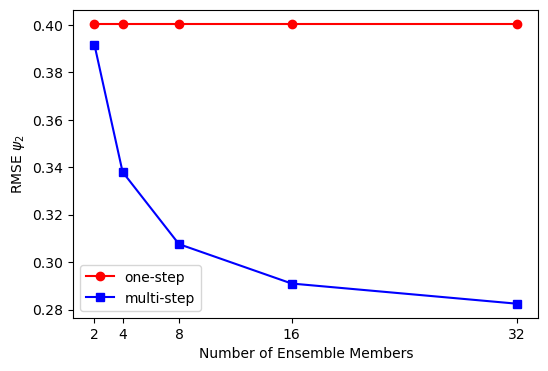

In [22]:
# Create the plot
plt.figure(figsize=(6, 4))
plt.plot(Ns, [rmse2_m_lsm] * len(Ns), label='one-step', linestyle='-', marker='o', color='red')
plt.plot(Ns, rmses2_m_cg, label='multi-step', linestyle='-', marker='s', color='blue')
plt.xlabel('Number of Ensemble Members')
plt.ylabel(r'RMSE $\psi_2$')
plt.xticks(Ns)
plt.legend()
plt.savefig('./Lagrangian_DA/Nens_L256.png', dpi=100)
plt.show()

## 3.4 Computational cost

In [2]:
# Load the data
data = np.load('../data/QG_DATA_Nt1000.npz')
psi1_k_t = data['psi1_k_t']
psi2_k_t = data['psi2_k_t']
# psi1_k_t_fine = data['psi1_k_t_fine']
dt = data['dt'].item()
s_rate = data['s_rate'].item()
nu = data['nu'].item()
topo = data['topo']
kd = data['kd'].item()
U = data['U'].item()
kb = data['kb'].item()
kappa = data['kappa'].item()
beta = data['beta'].item()
K = data['K'].item()
H = data['H'].item()
h_hat = data['h_hat']
data.close()
data = np.load('../data/obs_Nt1000.npz')
xt = data['xt']
yt = data['yt']
sigma_xy = data['sigma_xy'].item()
eigens = np.load('../data/eigens_K128_beta22.npz')
omega1 = eigens['omega1']
omega2 = eigens['omega2']
r1 = eigens['r1']
r2 = eigens['r2']
est_params = np.load('../data/est_paras_ou_K128_beta22_tr.npz')
gamma_est = est_params['gamma']
omega_est = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']
data = np.load('../data/Sigma_cali_CGDA_K128_beta22_tr.npz')
Sigma1 = data['Sigma1']
Sigma2 = data['Sigma2']

In [5]:
L = 256
r_cuts = [2, 4, 8, 16, 32]
style = 'circle'

# lsm da
N_chunk = 10
N = 10 # time steps
N_s = 2 # ensemble size
s_rate = 1
xt = xt[:, :N]
yt = yt[:, :N]
psi1_k_t = psi1_k_t[:, :, :N]
psi2_k_t = psi2_k_t[:, :, :N]
Sigma1_ = inv_truncate(Sigma1[:, None], 16, K, style)
Sigma2_ = inv_truncate(Sigma2[:, None], 16, K, style)

for r_cut in r_cuts:
    print('r_cut=', r_cut)
    psi_k_t, tau_k_t = layer2eigen(K, r_cut, r1, r2, psi1_k_t, psi2_k_t, style=style)
    lsm_da = Lagrangian_DA_OU(K, r1, r2, f_est, gamma_est, omega_est, sigma_est, r_cut, style)
    t0 = time()
    mu_t_lsm, R_t_lsm = lsm_da.forward(N, N_chunk, dt, s_rate=1, tracer=True, psi_k_t=psi_k_t, tau_k_t=tau_k_t, sigma_xy=sigma_xy, xt=xt.T, yt=yt.T)
    print('lsmda time=', time()-t0)

    Sigma1 = truncate(Sigma1_, r_cut, style)[:, 0]
    Sigma2 = truncate(Sigma2_, r_cut, style)[:, 0]
    cg_da = Lagrangian_DA_CG(K, kd, beta, kappa, nu, U, h_hat, r_cut, style)
    print('cgda forward R:')
    mu_t, R_t = cg_da.forward(N, N_chunk, dt, N_s, Sigma1, Sigma2, s_rate, psi2_k_t0=psi2_k_t[:,:,-N//s_rate], mu_eigen_t=mu_t_lsm[:,-N:] , R_eigen_t=R_t_lsm[:,-N:] , sigma=sigma_est, f=f_est, gamma=gamma_est, omega=omega_est, r1=r1, r2=r2)
    print('cgda constant R:')
    mu_t, R_t = cg_da.forward(N, N_chunk, dt, N_s, Sigma1, Sigma2, s_rate, forward_R=False, psi2_k_t0=psi2_k_t[:,:,-N//s_rate], mu_eigen_t=mu_t_lsm[:,-N:] , R_eigen_t=R_t_lsm[:,-N:] , sigma=sigma_est, f=f_est, gamma=gamma_est, omega=omega_est, r1=r1, r2=r2)

r_cut= 2
lsmda time 0.01918959617614746
cgda forward R:
0
t_sample= 0.0005631446838378906
t_getA= 0.0003628730773925781
t_meanvar= 0.0002219676971435547
t_forward= 0.0006499290466308594
1
t_sample= 0.00016164779663085938
t_getA= 0.0006139278411865234
t_meanvar= 0.00032901763916015625
t_forward= 0.0011091232299804688
cgda constant R:
0
t_sample= 0.00017189979553222656
t_getA= 0.0003781318664550781
t_meanvar= 9.703636169433594e-05
t_forward= 0.0005512237548828125
1
t_sample= 0.00031185150146484375
t_getA= 0.0002448558807373047
t_meanvar= 8.368492126464844e-05
t_forward= 0.0003829002380371094
r_cut= 4
lsmda time 0.041506052017211914
cgda forward R:
0
t_sample= 0.00024890899658203125
t_getA= 0.00430607795715332
t_meanvar= 0.012663841247558594
t_forward= 0.018934965133666992
1
t_sample= 0.0005478858947753906
t_getA= 0.004683017730712891
t_meanvar= 0.01990032196044922
t_forward= 0.024854183197021484
cgda constant R:
0
t_sample= 0.0014851093292236328
t_getA= 0.008921146392822266
t_meanvar= 0.

/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_DA.py:308: RuntimeWarning: invalid value encountered in multiply
  mu = mu0 + (a0 + a1 @ mu0) * dt + (R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_DA.py:308: RuntimeWarning: invalid value encountered in matmul
  mu = mu0 + (a0 + a1 @ mu0) * dt + (R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_DA.py:309: RuntimeWarning: invalid value encountered in multiply
  R = R0 + (a1R0 + a1R0.conj().T + np.diag(sigma_2_sq) - (R0A1_H) * InvBoB @ R0A1_H.conj().T) * dt
/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_DA.py:309: RuntimeWarning: invalid value encountered in matmul
  R = R0 + (a1R0 + a1R0.conj().T + np.diag(sigma_2_sq) - (R0A1_H) * InvBoB @ R0A1_H.conj().T) * dt


t_getA= 25.15111207962036
t_meanvar= 61.94293522834778
t_forward= 87.25545191764832
1
t_sample= 0.3350410461425781
t_getA= 23.047220945358276
t_meanvar= 63.029802560806274
t_forward= 86.25166702270508
cgda constant R:
0
t_sample= 0.27144908905029297


/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_DA.py:337: RuntimeWarning: invalid value encountered in multiply
  mu = mu0 + (a0 + a1 @ mu0) * dt + (R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_DA.py:337: RuntimeWarning: invalid value encountered in matmul
  mu = mu0 + (a0 + a1 @ mu0) * dt + (R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)


t_getA= 24.67391276359558
t_meanvar= 18.916118144989014
t_forward= 43.715153217315674
1
t_sample= 0.34422874450683594
t_getA= 22.207839965820312
t_meanvar= 16.176220417022705
t_forward= 38.48317575454712


In [41]:
t_lsmda = [0.01918959617614746, 0.041506052017211914, 0.3597140312194824, 2.8497719764709473, 38.52121686935425]

In [42]:
t_sample = [0.0005631446838378906+0.00016164779663085938, 0.00024890899658203125+0.0005478858947753906,0.0009882450103759766+0.0010230541229248047,0.02884197235107422+0.0369260311126709,0.254486083984375+0.3350410461425781]
t_getA = [0.0003628730773925781+0.0006139278411865234, 0.00430607795715332+0.004683017730712891,0.059262990951538086+0.05197596549987793,0.635552167892456+0.5551097393035889,25.15111207962036+23.047220945358276]
t_meanvar = [0.0002219676971435547+0.00032901763916015625, 0.012663841247558594+0.01990032196044922, 0.07828211784362793+0.04585552215576172,1.8872013092041016+1.6270208358764648,61.94293522834778+63.029802560806274]
t_cgda = [0.0006499290466308594+0.0011091232299804688, 0.018934965133666992+0.024854183197021484, 0.13843894004821777+0.09842896461486816,2.529102087020874+2.188143014907837,87.25545191764832+86.25166702270508]
t_mstep = np.array(t_sample) + np.array(t_cgda) + np.array(t_lsmda)

t_sample_constR = [0.00017189979553222656+0.00031185150146484375, 0.0014851093292236328+0.0005719661712646484, 0.0008628368377685547+0.001619100570678711,0.020591020584106445+0.016098737716674805,0.27144908905029297+0.34422874450683594]
t_getA_constR = [0.0003781318664550781+0.0002448558807373047, 0.008921146392822266+0.004220724105834961, 0.04392600059509277+0.04467320442199707,0.46088600158691406+0.4602019786834717,24.67391276359558+22.207839965820312]
t_meanvar_constR = [9.703636169433594e-05+8.368492126464844e-05,0.0040132999420166016+0.002941131591796875, 0.04349660873413086+0.03258252143859863,0.36041879653930664+0.37813591957092285,18.916118144989014+16.176220417022705]
t_cgda_constR = [0.0005512237548828125+0.0003829002380371094, 0.013525962829589844+0.007462978363037109, 0.09032011032104492+0.08133983612060547,0.8274109363555908+0.8470909595489502,43.715153217315674+38.48317575454712]
t_mstep_constR = np.array(t_sample_constR) + np.array(t_cgda_constR) + np.array(t_lsmda)

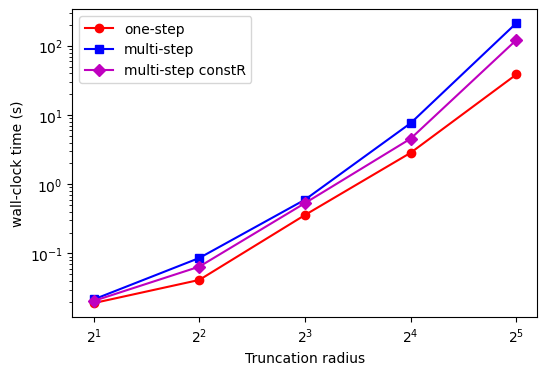

In [49]:
# Create the plot
plt.figure(figsize=(6, 4))
plt.plot(r_cuts, t_lsmda, label='one-step', linestyle='-', marker='o', color='red')
plt.plot(r_cuts, t_mstep, label='multi-step', linestyle='-', marker='s', color='blue')
plt.plot(r_cuts, t_mstep_constR, label='multi-step constR', linestyle='-', marker='D', color='m')
plt.xlabel('Truncation radius')
plt.ylabel(r'wall-clock time (s)')
plt.xticks(r_cuts)
plt.yscale('log', base=10)
plt.xscale('log', base=2)
plt.legend()
# plt.tight_layout()
plt.savefig('./Lagrangian_DA/compcost_r.png', dpi=100,bbox_inches='tight')
plt.show()

In [9]:
N_s = 32
r_cut = 16 
psi_k_t, tau_k_t = layer2eigen(K, r_cut, r1, r2, psi1_k_t, psi2_k_t, style=style)
lsm_da = Lagrangian_DA_OU(K, r1, r2, f_est, gamma_est, omega_est, sigma_est, r_cut, style)
t0 = time()
mu_t_lsm, R_t_lsm = lsm_da.forward(N, N_chunk, dt, s_rate=1, tracer=True, psi_k_t=psi_k_t, tau_k_t=tau_k_t, sigma_xy=sigma_xy, xt=xt.T, yt=yt.T)
print('lsmda time=', time()-t0)

Sigma1 = truncate(Sigma1_, r_cut, style)[:, 0]
Sigma2 = truncate(Sigma2_, r_cut, style)[:, 0]
cg_da = Lagrangian_DA_CG(K, kd, beta, kappa, nu, U, h_hat, r_cut, style)
print('cgda forward R:')
mu_t, R_t = cg_da.forward(N, N_chunk, dt, N_s, Sigma1, Sigma2, s_rate, psi2_k_t0=psi2_k_t[:,:,-N//s_rate], mu_eigen_t=mu_t_lsm[:,-N:] , R_eigen_t=R_t_lsm[:,-N:] , sigma=sigma_est, f=f_est, gamma=gamma_est, omega=omega_est, r1=r1, r2=r2)
print('cgda constant R:')
mu_t, R_t = cg_da.forward(N, N_chunk, dt, N_s, Sigma1, Sigma2, s_rate, forward_R=False, psi2_k_t0=psi2_k_t[:,:,-N//s_rate], mu_eigen_t=mu_t_lsm[:,-N:] , R_eigen_t=R_t_lsm[:,-N:] , sigma=sigma_est, f=f_est, gamma=gamma_est, omega=omega_est, r1=r1, r2=r2)

lsmda time= 2.5603036880493164
cgda forward R:
0
t_sample= 0.01870894432067871
t_getA= 0.43517494201660156
t_meanvar= 1.4302160739898682
t_forward= 1.8725576400756836
1
t_sample= 0.01942300796508789
t_getA= 0.436737060546875
t_meanvar= 1.3853206634521484
t_forward= 1.8285298347473145
2
t_sample= 0.013654947280883789
t_getA= 0.45678281784057617
t_meanvar= 1.3782477378845215
t_forward= 1.839859962463379
3
t_sample= 0.018685102462768555
t_getA= 0.43448495864868164
t_meanvar= 1.4473743438720703
t_forward= 1.8875679969787598
4
t_sample= 0.018629789352416992
t_getA= 0.4429349899291992
t_meanvar= 1.381657361984253
t_forward= 1.8301029205322266
5
t_sample= 0.014184951782226562
t_getA= 0.4529693126678467
t_meanvar= 1.410834789276123
t_forward= 1.8694159984588623
6
t_sample= 0.01677703857421875
t_getA= 0.48104071617126465
t_meanvar= 1.6275851726531982
t_forward= 2.1153197288513184
7
t_sample= 0.016682147979736328
t_getA= 0.46657419204711914
t_meanvar= 1.3808157444000244
t_forward= 1.853075981140

In [50]:
t_lsmda = 2.5603036880493164
t_sample = [
    0.01870894432067871, 0.01942300796508789, 0.013654947280883789, 0.018685102462768555,
    0.018629789352416992, 0.014184951782226562, 0.01677703857421875, 0.016682147979736328,
    0.02100992202758789, 0.01718616485595703, 0.017192840576171875, 0.018200159072875977,
    0.01427316665649414, 0.020399093627929688, 0.013387203216552734, 0.01712512969970703,
    0.019572973251342773, 0.01601099967956543, 0.015147924423217773, 0.019787073135375977,
    0.021162033081054688, 0.022531986236572266, 0.02100396156311035, 0.01887202262878418,
    0.0177459716796875, 0.01405191421508789, 0.0489346981048584, 0.02249908447265625,
    0.014920949935913086, 0.021043062210083008, 0.015314102172851562, 0.01620316505432129
]

t_getA = [
    0.43517494201660156, 0.436737060546875, 0.45678281784057617, 0.43448495864868164,
    0.4429349899291992, 0.4529693126678467, 0.48104071617126465, 0.46657419204711914,
    0.4446280002593994, 0.4458787441253662, 0.4585609436035156, 0.4754617214202881,
    0.4507269859313965, 0.45054197311401367, 0.4355199337005615, 0.44400596618652344,
    0.42204904556274414, 0.4493107795715332, 0.4393041133880615, 0.4484260082244873,
    0.44973278045654297, 0.4506528377532959, 0.42383694648742676, 0.44791197776794434,
    0.4439208507537842, 0.4346787929534912, 0.4181959629058838, 0.49303197860717773,
    0.4567840099334717, 0.4363558292388916, 0.44825220108032227, 0.44304490089416504
]

t_meanvar = [
    1.4302160739898682, 1.3853206634521484, 1.3782477378845215, 1.4473743438720703,
    1.381657361984253, 1.410834789276123, 1.6275851726531982, 1.3808157444000244,
    1.4760937690734863, 1.4411680698394775, 1.4217653274536133, 1.4873559474945068,
    1.4542386531829834, 1.5315220355987549, 1.4472086429595947, 1.4838156700134277,
    1.4409599304199219, 1.4892034530639648, 1.5575106143951416, 1.7699460983276367,
    1.5299160480499268, 1.6938471794128418, 1.9165217876434326, 1.6567270755767822,
    1.3920133113861084, 1.761866569519043, 1.5063891410827637, 1.5447447299957275,
    1.502190113067627, 1.4771342277526855, 1.4997804164886475, 1.4105944633483887
]

t_cgda = [
    1.8725576400756836, 1.828529834747314, 1.839859962463379, 1.8875679969787598,
    1.8301029205322266, 1.8694159984588623, 2.1153197288513184, 1.8530759811401367,
    1.929013967514038, 1.8910198211669922, 1.8858129978179932, 1.9725759029388428,
    1.9109058380126953, 1.986954927444458, 1.885957956314087, 1.932985782623291,
    1.8695979118347168, 1.9449360370635986, 2.0001378059387207, 2.224506139755249,
    1.9849340915679932, 2.152055025100708, 2.348623037338257, 2.1113550662994385,
    1.844120979309082, 2.205331325531006, 1.931427240371704, 2.0436031818389893,
    1.966947078704834, 1.9200201034545898, 1.954685926437378, 1.8582561016082764
]

t_sample_constR = [
    0.018446922302246094, 0.016395092010498047, 0.015736103057861328, 0.023400306701660156,
    0.016752958297729492, 0.01865696907043457, 0.01977705955505371, 0.01685810089111328,
    0.016225814819335938, 0.015866756439208984, 0.01716899871826172, 0.014252901077270508,
    0.015436172485351562, 0.017683029174804688, 0.02180194854736328, 0.01675105094909668,
    0.018934011459350586, 0.015620946884155273, 0.01656174659729004, 0.01494908332824707,
    0.017297029495239258, 0.015218973159790039, 0.017134666442871094, 0.01888275146484375,
    0.01432490348815918, 0.020824909210205078, 0.016405820846557617, 0.01695418357849121,
    0.015779972076416016, 0.016295194625854492, 0.023508071899414062, 0.01814126968383789
]

t_getA_constR = [
    0.45203304290771484, 0.43647313117980957, 0.4286530017852783, 0.4528782367706299,
    0.48252391815185547, 0.43045592308044434, 0.4320790767669678, 0.4297339916229248,
    0.44341588020324707, 0.45327091217041016, 0.4412059783935547, 0.4391601085662842,
    0.43433427810668945, 0.4382321834564209, 0.47289109230041504, 0.4551839828491211,
    0.4552769660949707, 0.42555904388427734, 0.44013309478759766, 0.43140578269958496,
    0.43886899948120117, 0.4533710479736328, 0.41921305656433105, 0.4500901699066162,
    0.42775797843933105, 0.43938708305358887, 0.4327969551086426, 0.4407317638397217,
    0.45378613471984863, 0.44721174240112305, 0.43639397621154785, 0.44249391555786133
]

t_meanvar_constR = [
    0.37578701972961426, 0.36880040168762207, 0.4380760192871094, 0.4010467529296875,
    0.389512300491333, 0.388960599899292, 0.37278318405151367, 0.38497424125671387,
    0.36142468452453613, 0.39576101303100586, 0.4123251438140869, 0.3826181888580322,
    0.37920045852661133, 0.4471254348754883, 0.3274977207183838, 0.3692965507507324,
    0.39713621139526367, 0.4086897373199463, 0.3735487461090088, 0.44120121002197266,
    0.3614833354949951, 0.3713517189025879, 0.40096092224121094, 0.3500492572784424,
    0.45142579078674316, 0.3763613700866699, 0.4076707363128662, 0.4356522560119629,
    0.3643946647644043, 0.41905856132507324, 0.38405776023864746, 0.37720203399658203
]

t_cgda_constR = [
    0.833676815032959, 0.8100481033325195, 0.8747220039367676, 0.8571090698242188,
    0.8790919780731201, 0.8241980075836182, 0.8116021156311035, 0.8176918029785156,
    0.8107059001922607, 0.8556487560272217, 0.8585898876190186, 0.8293640613555908,
    0.818169116973877, 0.894503116607666, 0.8051011562347412, 0.8301150798797607,
    0.8566350936889648, 0.837806224822998, 0.8166160583496094, 0.8775858879089355,
    0.8054521083831787, 0.8298728466033936, 0.8259682655334473, 0.8055500984191895,
    0.8833060264587402, 0.8206539154052734, 0.8455469608306885, 0.880601167678833,
    0.8237659931182861, 0.870424747467041, 0.8238511085510254, 0.8251149654388428
]

In [51]:
t_mstep_ = np.array(t_sample) + np.array(t_cgda) 
t_mstep_constR_ = np.array(t_sample_constR) + np.array(t_cgda_constR)
N_ss = [2, 4, 8, 16, 32]
t_mstep = []
t_mstep_constR = []
for Ns in N_ss:
    t_mstep.append(np.sum(t_mstep_[:Ns])+ t_lsmda)
    t_mstep_constR.append(np.sum(t_mstep_constR_[:Ns])+ t_lsmda)

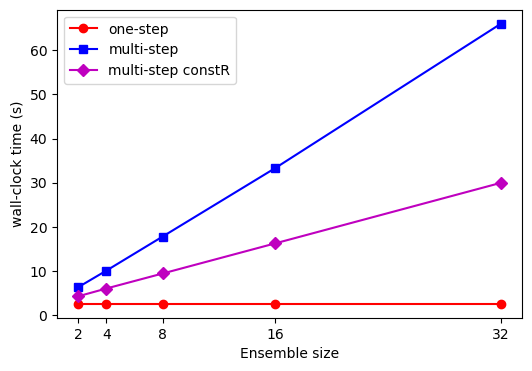

In [53]:
# Create the plot
plt.figure(figsize=(6, 4))
plt.plot(N_ss, [t_lsmda]*len(N_ss), label='one-step', linestyle='-', marker='o', color='red')
plt.plot(N_ss, t_mstep, label='multi-step', linestyle='-', marker='s', color='blue')
plt.plot(N_ss, t_mstep_constR, label='multi-step constR', linestyle='-', marker='D', color='m')
plt.xlabel('Ensemble size')
plt.ylabel(r'wall-clock time (s)')
plt.xticks(r_cuts)
# plt.yscale('log', base=10)
plt.legend()
plt.savefig('./Lagrangian_DA/compcost_ens.png', dpi=100,bbox_inches='tight')
plt.show()

#  Appendix

## A.1 Comparison of LSM and CG model free forecasts

In [3]:
# load data
data_path = '../qg/QG_DATA_topo40_nu1e-12_beta22_K128_dt2e-3_subs.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    # psi1_k_t_fine = np.transpose(file['psi_1_t_fine'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    s_rate = int(file['s_rate'][()][0,0])
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
# psi1_k_t_fine = psi1_k_t_fine['real'] + 1j * psi1_k_t_fine['imag']
h_hat = np.fft.fft2(topo)
# print('psi1_k_t.shape',psi1_k_t.shape)

eigens = np.load('../data/eigens_K128_beta22.npz')
r1 = eigens['r1']
r2 = eigens['r2']
data = np.load('../data/Sigma_cali_CGDA_K128_beta22_tr.npz')
Sigma1 = data['Sigma1']
Sigma2 = data['Sigma2']

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_1_t_fine', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'utz', 'vb']>


In [6]:
# truncate parameter
r_cut = 16
style = 'circle'

In [7]:
# init
N = 2000 
psi1_k_t0 = psi1_k_t[:,:,-N//s_rate]
psi2_k_t0 = psi2_k_t[:,:,-N//s_rate]

In [6]:
# free forecast
cg_da = Lagrangian_DA_CG(K, kd, beta, kappa, nu, U, h_hat, r_cut, style)
psi1_k_cg_cb, psi2_k_cg_cb = cg_da.forward_model(N, dt,psi1_k_t0, psi2_k_t0, cali='sigma', sigma_1=Sigma1, sigma_2=Sigma2)
                                                 
# save data
cg_run = {
    'psi1_k': psi1_k_cg_cb,
    'psi2_k': psi2_k_cg_cb,
    'r_cut':r_cut,
    'style':style,
    'dt': dt
}
np.savez('../data/CG_cgcali_K128_beta22_tr16.npz', **cg_run)

/grad/wang3262/Proj_1_LagrangeDA/code/Lagrangian_DA.py:136: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / invCk
/grad/wang3262/Proj_1_LagrangeDA/code/Lagrangian_DA.py:812: RuntimeWarning: overflow encountered in matmul
  psi1_k_t[:, i] = psi1_k_t[:, i-1] + (A0 + A1 @ psi2_k_t[:, i-1]) * dt + sigma_1 * noise[:, 0, i] * np.sqrt(dt)
/grad/wang3262/Proj_1_LagrangeDA/code/Lagrangian_DA.py:812: RuntimeWarning: invalid value encountered in matmul
  psi1_k_t[:, i] = psi1_k_t[:, i-1] + (A0 + A1 @ psi2_k_t[:, i-1]) * dt + sigma_1 * noise[:, 0, i] * np.sqrt(dt)
/grad/wang3262/Proj_1_LagrangeDA/code/Lagrangian_DA.py:813: RuntimeWarning: overflow encountered in matmul
  psi2_k_t[:, i] = psi2_k_t[:, i-1] + (a0 + a1 @ psi2_k_t[:, i-1]) * dt + sigma_2 * noise[:, 1, i] * np.sqrt(dt)
/grad/wang3262/Proj_1_LagrangeDA/code/Lagrangian_DA.py:813: RuntimeWarning: invalid value encountered in matmul
  psi2_k_t[:, i] = psi2_k_t[:, i-1] + (a0 + a1 @ psi2_k_t[:, i-1]) * dt + sigma_2 * noise[:, 

In [7]:
# free forecast
psi1_k_cg_bt, psi2_k_cg_bt = cg_da.forward_model(N, dt,psi1_k_t0, psi2_k_t0, cali=False)
                                                 
# save data
cg_run = {
    'psi1_k': psi1_k_cg_bt,
    'psi2_k': psi2_k_cg_bt,
    'r_cut':r_cut,
    'style':style,
    'dt': dt
}
np.savez('../data/CG_cgbare_K128_beta22_tr16.npz', **cg_run)

/grad/wang3262/Proj_1_LagrangeDA/code/Lagrangian_DA.py:825: RuntimeWarning: overflow encountered in matmul
  psi1_k_t[:, i] = psi1_k_t[:, i-1] + (A0 + A1 @ psi2_k_t[:, i-1]) * dt
/grad/wang3262/Proj_1_LagrangeDA/code/Lagrangian_DA.py:825: RuntimeWarning: invalid value encountered in matmul
  psi1_k_t[:, i] = psi1_k_t[:, i-1] + (A0 + A1 @ psi2_k_t[:, i-1]) * dt
/grad/wang3262/Proj_1_LagrangeDA/code/Lagrangian_DA.py:826: RuntimeWarning: overflow encountered in matmul
  psi2_k_t[:, i] = psi2_k_t[:, i-1] + (a0 + a1 @ psi2_k_t[:, i-1]) * dt
/grad/wang3262/Proj_1_LagrangeDA/code/Lagrangian_DA.py:826: RuntimeWarning: invalid value encountered in matmul
  psi2_k_t[:, i] = psi2_k_t[:, i-1] + (a0 + a1 @ psi2_k_t[:, i-1]) * dt


In [9]:
# free forecast linear bare truncation
cg_da = Lagrangian_DA_CG(K, kd, beta, kappa, nu, U, h_hat, r_cut, style)
psi1_k_ln_bt, psi2_k_ln_bt = cg_da.forward_model(N, dt,psi1_k_t0, psi2_k_t0, cali=False)
                                                 
# save data
cg_run = {
    'psi1_k': psi1_k_ln_bt,
    'psi2_k': psi2_k_ln_bt,
    'r_cut':r_cut,
    'style':style,
    'dt': dt
}
np.savez('../data/OU_lnbare_K128_beta22_tr16.npz', **cg_run)

/tmp/ipykernel_1337958/2981249852.py:136: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / invCk


In [8]:
# Run OU process
est_params = np.load('../data/est_paras_ou_K128_beta22_tr.npz')
gamma_est = est_params['gamma']
omega_est = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']

psi_k_t, tau_k_t = layer2eigen(K, r_cut, r1, r2, psi1_k_t, psi2_k_t, style=style)
# get the initial condition
psi_k0 = psi_k_t[:,:,-N//s_rate]
tau_k0 = tau_k_t[:,:,-N//s_rate]
psi_k, tau_k = run_OU(psi_k0, tau_k0, K, N, dt, r_cut, r1, r2, gamma_est, omega_est, f_est, sigma_est, style=style, s_rate=s_rate, corr_noise=False)
psi1_k_ln_cb, psi2_k_ln_cb= eigen2layer(K,r_cut,r1,r2,psi_k,tau_k,style)

# save data
ou_run = {
    'psi1_k': psi1_k_ln_cb,
    'psi2_k': psi2_k_ln_cb,
    'r_cut':r_cut,
    'style':style,
    'dt': dt
}
np.savez('../data/OU_cali_K128_beta22_tr16.npz', **ou_run)

In [11]:
cg_run = np.load('../data/CG_cgbare_K128_beta22_tr16.npz')
psi1_k_cg_bt = cg_run['psi1_k']
psi2_k_cg_bt = cg_run['psi2_k']
cg_run = np.load('../data/CG_cgcali_K128_beta22_tr16.npz')
psi1_k_cg_cb = cg_run['psi1_k']
psi2_k_cg_cb = cg_run['psi2_k']
ou_run = np.load('../data/OU_lnbare_K128_beta22_tr16.npz')
psi1_k_ln_bt = ou_run['psi1_k']
psi2_k_ln_bt = ou_run['psi2_k']
ou_run = np.load('../data/OU_cali_K128_beta22_tr16.npz')
psi1_k_ln_cb = ou_run['psi1_k']
psi2_k_ln_cb = ou_run['psi2_k']

In [12]:
psi1_k_ln_bt.shape

(797, 2000)

In [13]:
psi1_k_ln_bt = inv_truncate(psi1_k_ln_bt, r_cut, K, style)
psi2_k_ln_bt = inv_truncate(psi2_k_ln_bt, r_cut, K, style)
psi1_k_cg_bt = inv_truncate(psi1_k_cg_bt, r_cut, K, style)
psi2_k_cg_bt = inv_truncate(psi2_k_cg_bt, r_cut, K, style)
psi1_k_cg_cb = inv_truncate(psi1_k_cg_cb, r_cut, K, style)
psi2_k_cg_cb = inv_truncate(psi2_k_cg_cb, r_cut, K, style)

In [14]:
# ifft to real space
interv = 1
psi1_t = ifftnroll(K, psi1_k_t[:, :, -N//s_rate::interv])
psi2_t = ifftnroll(K, psi2_k_t[:, :, -N//s_rate::interv])
psi1_ln_bt = ifftnroll(K, psi1_k_ln_bt[:, :, -N::s_rate*interv]);
psi2_ln_bt = ifftnroll(K, psi2_k_ln_bt[:, :, -N::s_rate*interv]);
psi1_cg_bt = ifftnroll(K, psi1_k_cg_bt[:, :, -N::s_rate*interv])
psi2_cg_bt = ifftnroll(K, psi2_k_cg_bt[:, :, -N::s_rate*interv])
psi1_ln_cb = ifftnroll(K, psi1_k_ln_cb[:, :, -N//s_rate::interv])
psi2_ln_cb = ifftnroll(K, psi2_k_ln_cb[:, :, -N//s_rate::interv])
psi1_cg_cb = ifftnroll(K, psi1_k_cg_cb[:, :, -N::s_rate*interv]) 
psi2_cg_cb = ifftnroll(K, psi2_k_cg_cb[:, :, -N::s_rate*interv])

/tmp/ipykernel_1337958/3653608589.py:4: RuntimeWarning: overflow encountered in square
  rmse1_t_cg_bt = np.sqrt(np.mean((psi1_cg_bt - psi1_t)**2, axis=(0,1)))
/tmp/ipykernel_1337958/3653608589.py:5: RuntimeWarning: overflow encountered in square
  rmse2_t_cg_bt = np.sqrt(np.mean((psi2_cg_bt - psi2_t)**2, axis=(0,1)))


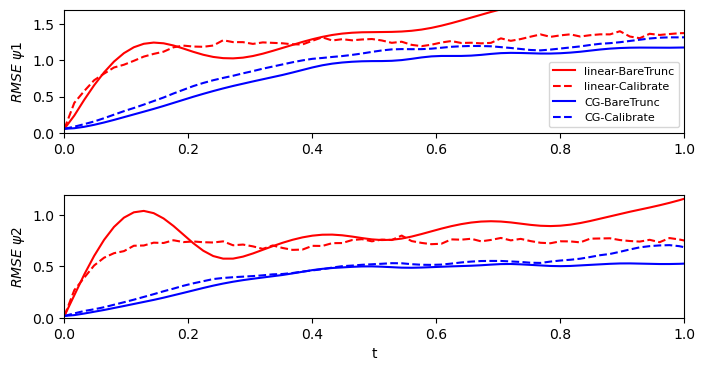

In [23]:
# Plot
rmse1_t_ln_bt = np.sqrt(np.mean((psi1_ln_bt - psi1_t)**2, axis=(0,1)))
rmse2_t_ln_bt = np.sqrt(np.mean((psi2_ln_bt - psi2_t)**2, axis=(0,1)))
rmse1_t_cg_bt = np.sqrt(np.mean((psi1_cg_bt - psi1_t)**2, axis=(0,1)))
rmse2_t_cg_bt = np.sqrt(np.mean((psi2_cg_bt - psi2_t)**2, axis=(0,1)))
rmse1_t_ln_cb = np.sqrt(np.mean((psi1_ln_cb - psi1_t)**2, axis=(0,1)))
rmse2_t_ln_cb = np.sqrt(np.mean((psi2_ln_cb - psi2_t)**2, axis=(0,1)))
rmse1_t_cg_cb = np.sqrt(np.mean((psi1_cg_cb - psi1_t)**2, axis=(0,1)))
rmse2_t_cg_cb = np.sqrt(np.mean((psi2_cg_cb - psi2_t)**2, axis=(0,1)))

sel0 = 0//(interv*s_rate); sel1 = N//(interv*s_rate) # plot time range
xlim = (0,1)
ylim = (0,1.7)
xaxis = np.arange(sel0*(interv*s_rate)*dt, sel1*(interv*s_rate)*dt, interv*s_rate*dt)

fig = plt.figure(figsize=(8,4))
widths = [7]
heights = [1, 1]
spec = fig.add_gridspec(ncols=1, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])

# plot time series
ax1.plot(xaxis, rmse1_t_ln_bt[sel0:sel1], 'r', label='linear-BareTrunc')
ax1.plot(xaxis, rmse1_t_ln_cb[sel0:sel1], 'r--', label='linear-Calibrate')
ax1.plot(xaxis, rmse1_t_cg_bt[sel0:sel1], 'b', label='CG-BareTrunc')
ax1.plot(xaxis, rmse1_t_cg_cb[sel0:sel1], 'b--', label='CG-Calibrate')
ax1.set_xlim(sel0*(interv*s_rate)*dt, sel1*(interv*s_rate)*dt)
ax1.set_ylabel('$RMSE \ \psi1$')
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
# ax1.set_yscale('log', base=10) 
ax1.legend(prop={'size': 8})

ax2.plot(xaxis, rmse2_t_ln_bt[sel0:sel1], 'r', label='linear-BareTrunc')
ax2.plot(xaxis, rmse2_t_ln_cb[sel0:sel1], 'r--', label='linear-Calibrate')
ax2.plot(xaxis, rmse2_t_cg_bt[sel0:sel1], 'b', label='CG-BareTrunc')
ax2.plot(xaxis, rmse2_t_cg_cb[sel0:sel1], 'b--', label='CG-Calibrate')
ax2.set_xlim(sel0*(interv*s_rate)*dt, sel1*(interv*s_rate)*dt)
ax2.set_ylabel(r'$RMSE\  \psi2$')
ax2.set_xlabel('t')
ax2.set_xlim(xlim)
ax2.set_ylim(0,1.2)
# ax2.set_yscale('log', base=10) 

plt.savefig('./Lagrangian_DA/freeforecast_rmse.png',dpi=100)
plt.show()

## A.2 Comparison of LSM-DA and CG-DA with upper layer fully observed

In [2]:
# load data
data_path = '../qg/QG_DATA_topo40_nu1e-12_beta22_K128_dt2e-3_subs.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    # psi1_k_t_fine = np.transpose(file['psi_1_t_fine'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    s_rate = int(file['s_rate'][()][0,0])
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
# psi1_k_t_fine = psi1_k_t_fine['real'] + 1j * psi1_k_t_fine['imag']
h_hat = np.fft.fft2(topo)
# print('psi1_k_t.shape',psi1_k_t.shape)
# load data of LSM
eigens = np.load('../data/eigens_K128_beta22.npz')
r1 = eigens['r1']
r2 = eigens['r2']

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_1_t_fine', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'utz', 'vb']>


In [3]:
# truncate parameter
r_cut = 16
style = 'circle'

In [4]:
# load DA data
da_pos = np.load('../data/LSMDA_pos_K128_beta22_tr16_flow.npz')
mu_t_lsm = da_pos['mu_t']
da_pos = np.load('../data/CGDA_pos_K128_beta22_tr16_flow.npz')
mu_t_cg = da_pos['mu_t']

In [8]:
N=200000

In [15]:
mu_t_lsm = mu_t_lsm[:, ::s_rate]
mu_t_lsm.shape

(797, 25000)

In [9]:
psi2_k_pos_lsm = inv_truncate(mu_t_lsm, r_cut, K, style)
psi2_k_pos_cg = inv_truncate(mu_t_cg, r_cut, K, style)

In [10]:
# ifft to real space
psi1_t = ifftnroll(K, psi1_k_t[:, :, 12500:N//s_rate])
psi2_t = ifftnroll(K, psi2_k_t[:, :, 12500:N//s_rate])
psi2_pos_lsm = ifftnroll(K, psi2_k_pos_lsm[:, :, 12500:N//s_rate])
psi2_pos_cg = ifftnroll(K, psi2_k_pos_cg)

In [11]:
def plot_rmses1(dt, sel0, sel1, s_rate, interv, xlim, data1, labels, colors):
	xaxis = np.arange(sel0*(s_rate)*dt, sel1*(s_rate)*dt, interv*s_rate*dt)
	fig = plt.figure(figsize=(8,2))
	# plot time series
	for i, data in enumerate(data1):
		plt.plot(xaxis, data[sel0:sel1:interv], colors[i], label=labels[i])

	plt.xlim(sel0*(s_rate)*dt, sel1*(s_rate)*dt)
	plt.ylabel(r'$RMSE\ \psi_2$')
	plt.xlabel('t')
	plt.xlim(xlim)
	plt.legend(prop={'size': 8})

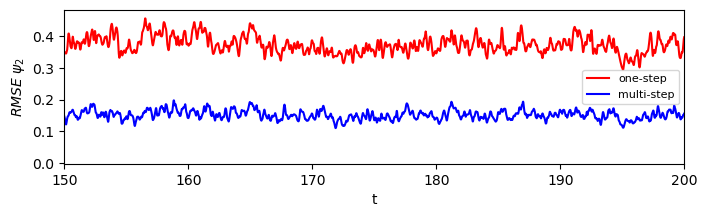

In [17]:
# Plot
rmse2_t_lsm = np.sqrt(np.mean((psi2_pos_lsm - psi2_t)**2, axis=(0,1)))
rmse2_t_cg = np.sqrt(np.mean((psi2_pos_cg - psi2_t)**2, axis=(0,1)))
data1 = [rmse2_t_lsm, rmse2_t_cg]
interv = 1
sel0 = 0//(s_rate); sel1 = 100000//(s_rate) # plot time range
xlim = (150,200)
labels = ['one-step', 'multi-step']
colors = ['r', 'b']
plot_rmses1(dt, sel0, sel1, s_rate, interv, xlim, data1, labels, colors)
plt.savefig('./Lagrangian_DA/rmses_K128_beta22_tr16_real_flowobs.png',dpi=100)
plt.show()

In [18]:
# RMSE
n_start = 0 # spin up time
rmse2_xy = np.sqrt(np.mean((psi2_pos_lsm[:,:,n_start:] - psi2_t[:,:,n_start:])**2, axis=(0,1)))
rmse2_m = np.mean(rmse2_xy)
print('LSM DA')
print('RMSE(lower layer):', rmse2_m)

rmse2_xy_cg = np.sqrt(np.mean((psi2_pos_cg[:,:,n_start:] - psi2_t[:,:,n_start:])**2, axis=(0,1)))
rmse2_m_cg = np.mean(rmse2_xy_cg)
print('CG DA')
print('RMSE(lower layer):', rmse2_m_cg)

LSM DA
RMSE(lower layer): 0.3689669018067589
CG DA
RMSE(lower layer): 0.15041449168289808
